In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import numpy as np
from data_process.shadow_render import render_shadow
import matplotlib.pyplot as plt

import torch
from ssn import ssn_dataset
from torchvision import transforms, utils
import numpy as np
from utils.net_utils import show_batch, show_light_batch
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from skimage.transform import resize

In [3]:
from valid_relight_ssn import predict, compute_ibl

norm: batch_norm bilinear: True activation: prelu
Device:  cpu


In [9]:
import matplotlib.pyplot as plt
def show_np(img, title='', cmap=None):
    plt.figure(figsize=(15,10))
    plt.title(title)
    plt.imshow(img, cmap=cmap)
    plt.show()
    

In [178]:
from ssn.ssn_dataset import Mask_Transform, ToTensor, IBL_Transform

def show_np(img, cmap='gray', title=''):
    h,w,c = img.shape
    
    plt.figure(figsize=(15,10))
    plt.title(title)
    if c == 1:
        plt.imshow(np.squeeze(img), cmap=cmap, interpolation='bilinear')
    else:
        plt.imshow(np.squeeze(img),  interpolation='bilinear')
    plt.show()
    
def to_one_batch(img_tensor):
    c,h,w = img_tensor.size()
    return img_tensor.view(1,c,h,w)

def to_numpy(one_batch):
    return one_batch[0].detach().cpu().numpy().transpose((1,2,0))

def png_to_3channel(img):
    """ mask image from 4 channel png to 3 channel"""
    h,w,c = img.shape
    if c != 4:
        print("image is not 4 channel")
        return img
    
    out_img, alpha = img[:,:,0:3]/255.0, img[:,:,3]/255.0
    out_img[:,:,0] = out_img[:,:,0] * alpha
    out_img[:,:,1] = out_img[:,:,1] * alpha
    out_img[:,:,2] = out_img[:,:,2] * alpha
    out_img = out_img * 255.9
    out_img = out_img.astype(np.uint8)
    return out_img

def padding_image(img, padding_size_w, padding_size_h):
    """ padding an image with a padding size """
    padding_size_w = int(padding_size_w)
    padding_size_h = int(padding_size_h)
    
    if padding_size_w == 0 and padding_size_h == 0:
        return img
    
    h, w = img.shape[:2]
    if len(img.shape) == 2:
        c = 1
    else:
        c = img.shape[-1]
    
    img = img.reshape((h,w,c))
    out_img = np.zeros((h + 2 * padding_size_h, w + 2 * padding_size_w, c),dtype=np.float64)
    out_img[padding_size_h:padding_size_h + h, padding_size_w:padding_size_w + w, 0:c] = img[:,:,0:c]
    return out_img

def crop_bb(img_mask):
    img_mask = img_mask[:,:,0] + img_mask[:,:,1] + img_mask[:,:,2]
    i, j = np.where(img_mask != 0)
    
    min_i, min_j = np.min(i), np.min(j)
    max_i, max_j = np.max(i), np.max(j)
    
    return min_i, min_j, max_i, max_j

def real_to_mask(img, mask_size=30):
    mask = img[:,:,-1]
    img = png_to_3channel(img)
    
    # crop the bb
    min_i, min_j, max_i, max_j = crop_bb(img)
    img = img[min_i:max_i, min_j:max_j, :]
    mask = mask[min_i:max_i, min_j:max_j]
    
    resize_w, resize_h = mask_size, int(mask_size * (max_i-min_i)/(max_j-min_j))
    img = resize(img, (resize_h, resize_w))
    img = padding_image(np.array(img), (256 - resize_w)//2, (256 - resize_h)//2)
    
    mask = resize(mask, (resize_h, resize_w))
    mask = padding_image(mask, (256 - resize_w)//2, (256 - resize_h)//2)
    
    thresh_hold = 0.3
    mask[np.where(mask < thresh_hold)] = 0.0
    mask[np.where(mask >= thresh_hold)] = 1.0
    
    mask = np.squeeze((mask * 255.9).astype(np.uint8))
    mask = np.array([mask,] * 3).transpose((1,2,0))
    
    return img, mask

def merge_result(mask, shadow):
    h,w,c = shadow.shape
    if c==1:
        merged = np.zeros((h,w,3), dtype=shadow.dtype)
        merged[:,:,0], merged[:,:,1], merged[:,:,2] = shadow[:,:,0],shadow[:,:,0],shadow[:,:,0]
    else:
        merged = np.copy(shadow)
    
    merged[np.where(mask!=0)] = mask[np.where(mask!=0)]
    return merged

def plot_result(ibl, shadow, mask, title='', save_path=''):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    fig.set_size_inches(20,15)
    fig.suptitle(title)
    ax1.imshow(np.squeeze(ibl),cmap='gray')
    ax2.imshow(np.squeeze(shadow), cmap='plasma')
    ax3.imshow(merge_result(mask, shadow))
    
    if save_path != '':
        fig.savefig(save_path)

img_trnsf = transforms.Compose([
    Mask_Transform(),
    ToTensor()
])
ibl_trnsf = transforms.Compose([
    # IBL_Transform(),
    ToTensor()
])

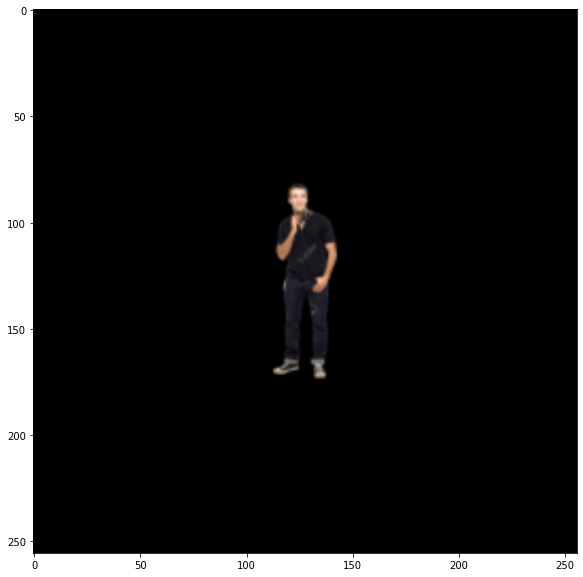

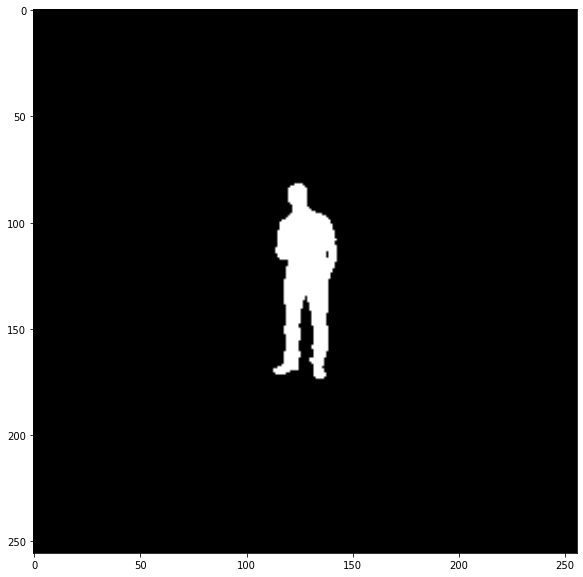

In [179]:
testing_fname = '/home/ysheng/Dataset/soft_shadow/real_human_testing_set/10944340-young-man-standing.png'

testing_img = Image.open(testing_fname)
testing_img, testing_mask = real_to_mask(np.array(testing_img))

show_np(testing_img)
show_np(testing_mask)

In [169]:
from ssn.ssn import Relight_SSN
import os

device = torch.device("cpu")
# device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
model = Relight_SSN(1,1)
weight_file = os.path.join('weights', 'l1 loss_04-April-12-06-AM.pt')
checkpoint = torch.load(weight_file, map_location=device)    
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])

Device:  cpu


<All keys matched successfully>

In [60]:
def flip_back(ibls, shadow):
    """ ibls: list of np ibl
        shadow: np image
    """ 
    sum_scale = 0
    for ibl in ibls:
        sum_scale += np.max(ibl)
    return sum_scale - shadow

In [180]:
experiment_path = 'results/exps'
os.makedirs(experiment_path, exist_ok=True)

## Multiple IBL







  0%|          | 0/11 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).






  9%|▉         | 1/11 [00:01<00:16,  1.65s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).






 18%|█▊        | 2/11 [00:03<00:15,  1.71s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).






 27%|██▋       | 3/11 [00:05<00:13,  1.71s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).






 36%|███▋      | 4/11 [00:07<00:12,  1.84s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).






 45%|████▌     | 5/11 [00:09<00:11,  1.86s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).






 55%|█████▍    | 6/11 [00:11<0

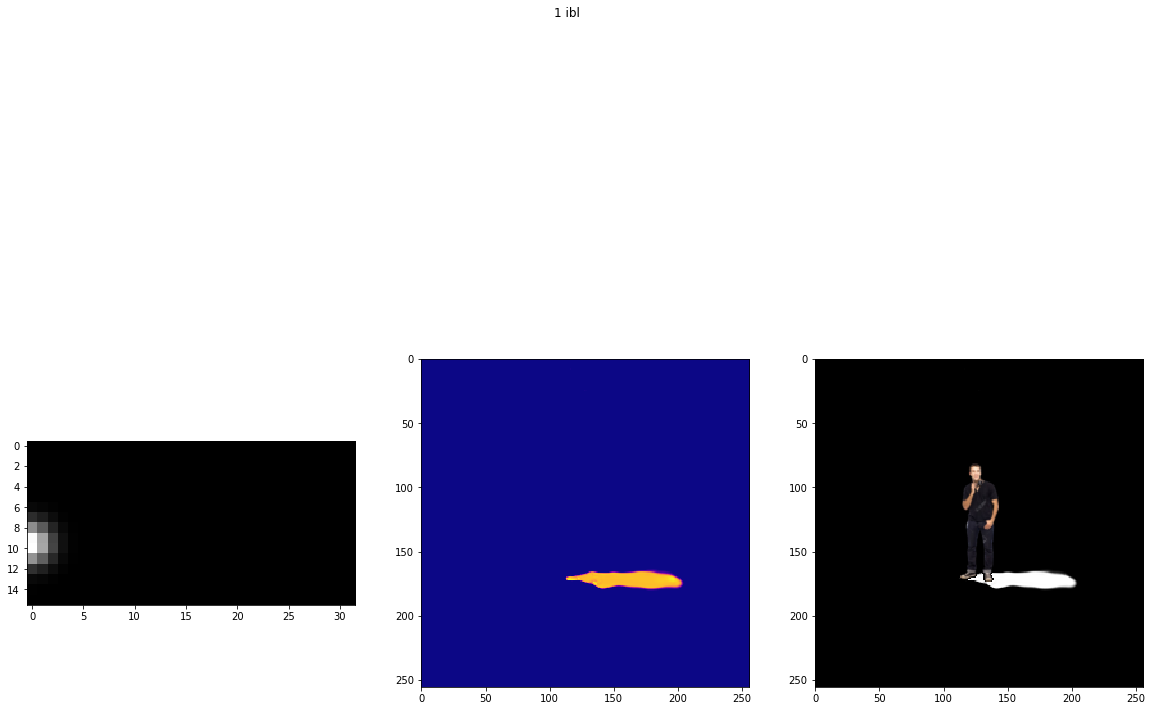

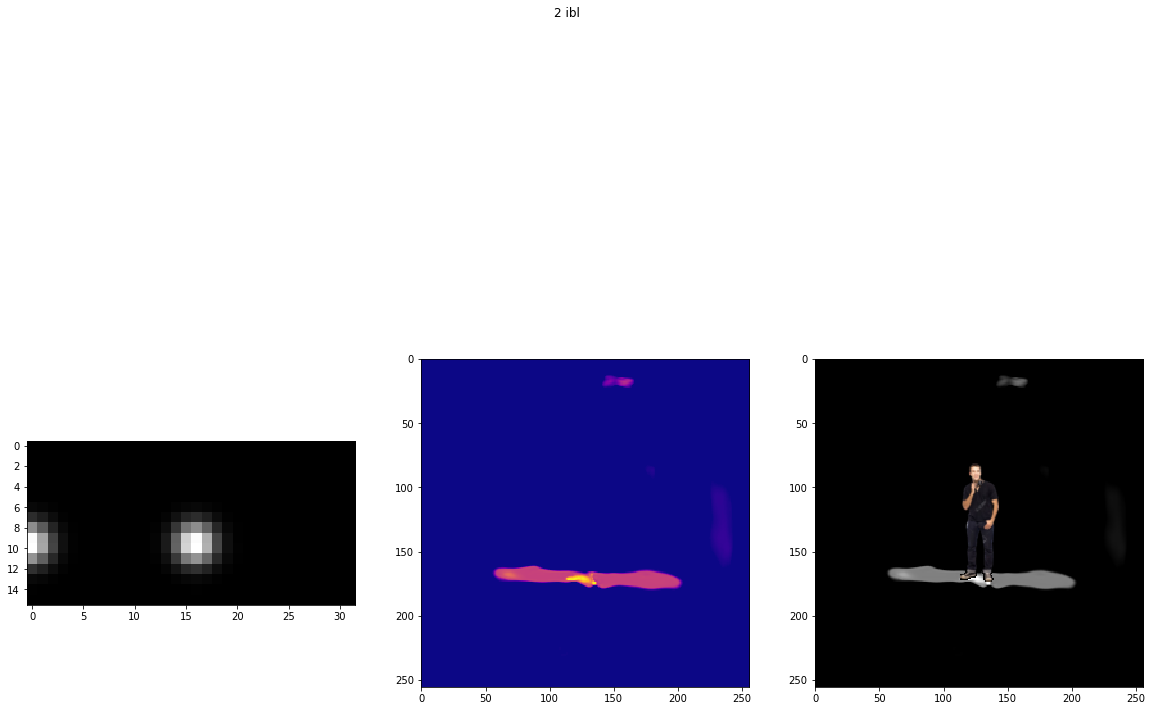

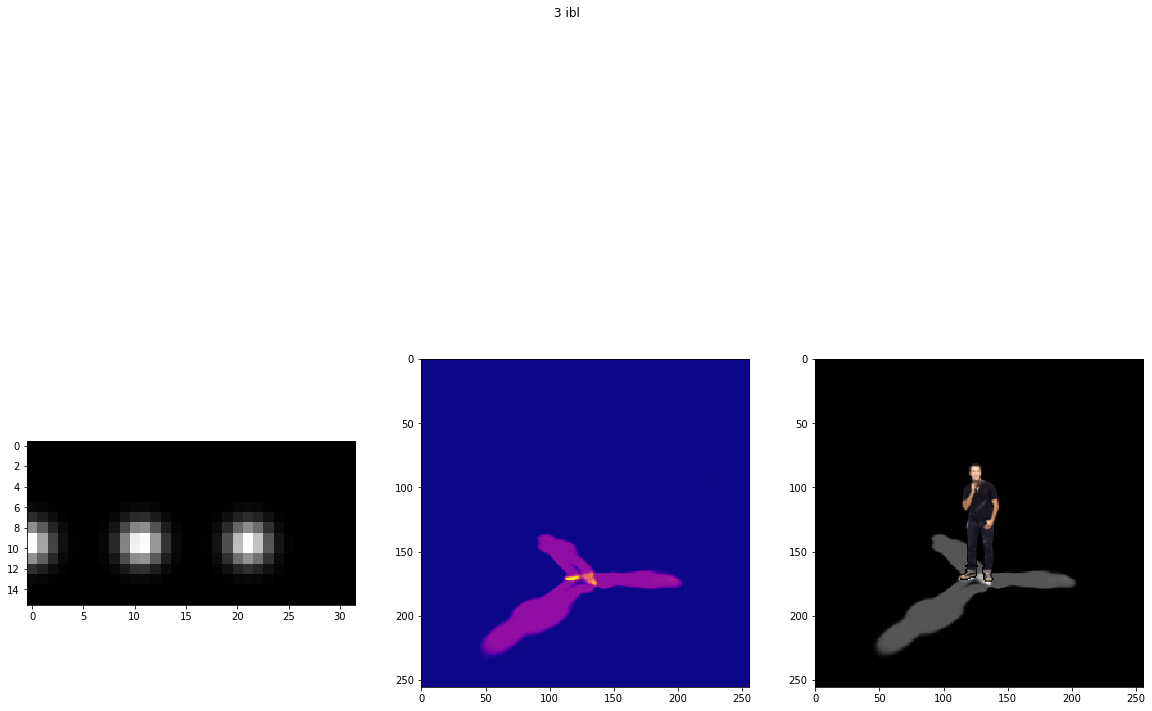

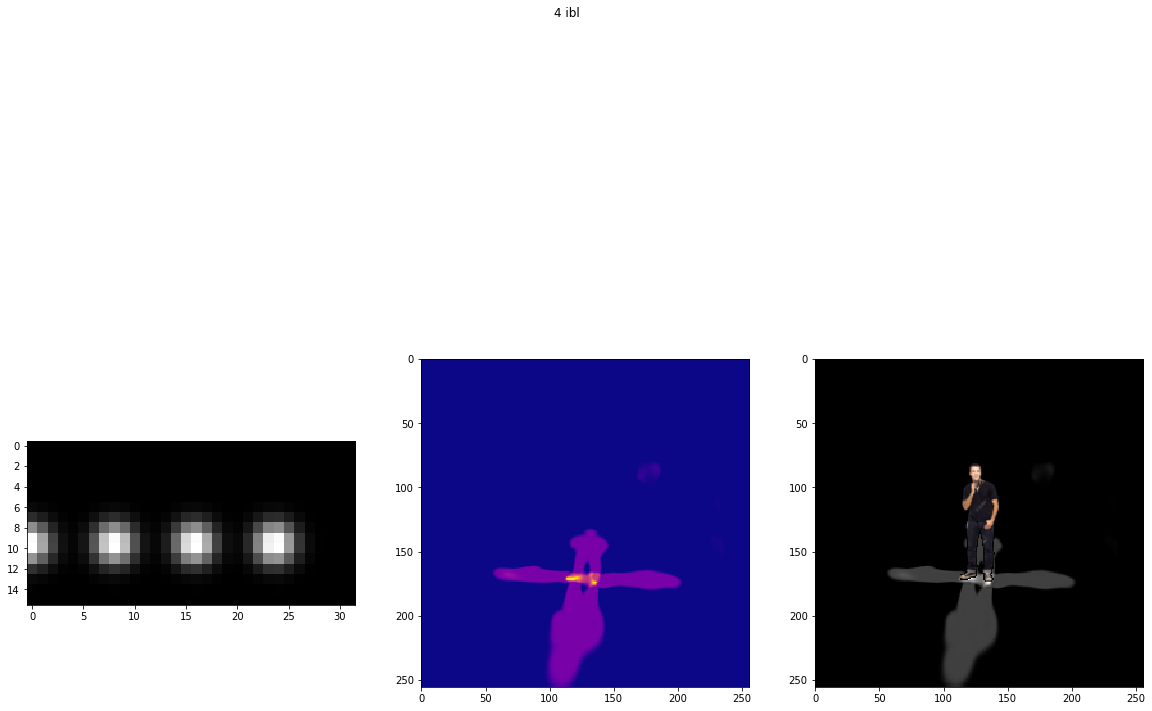

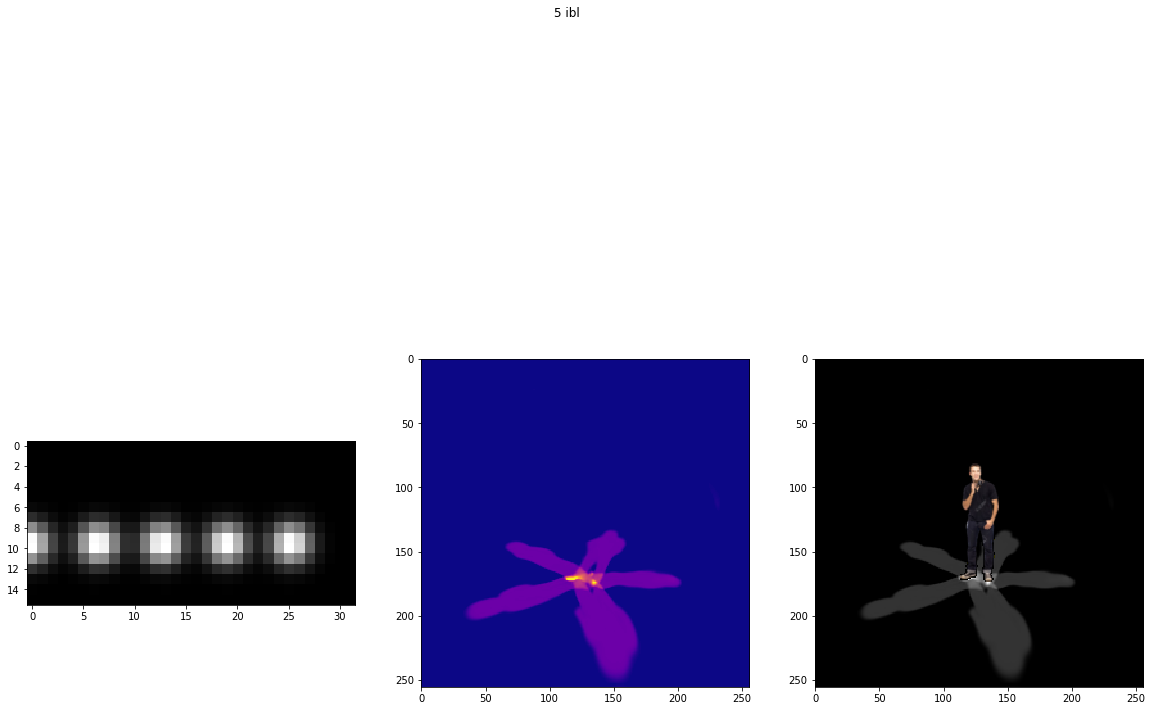

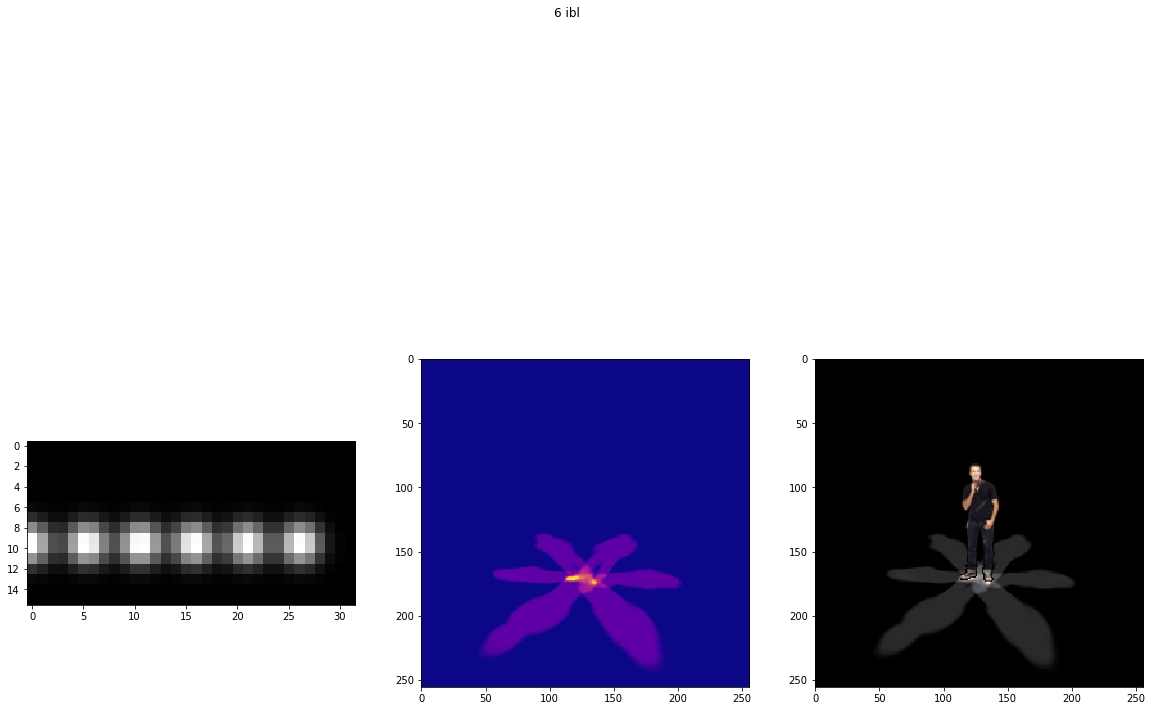

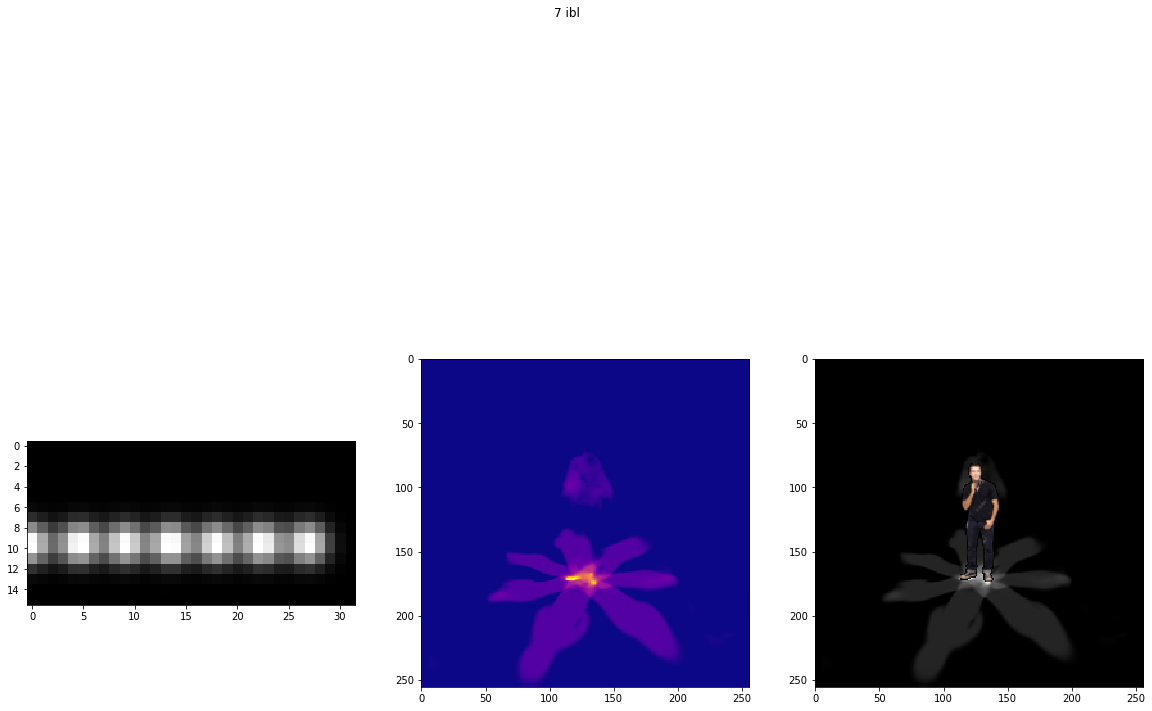

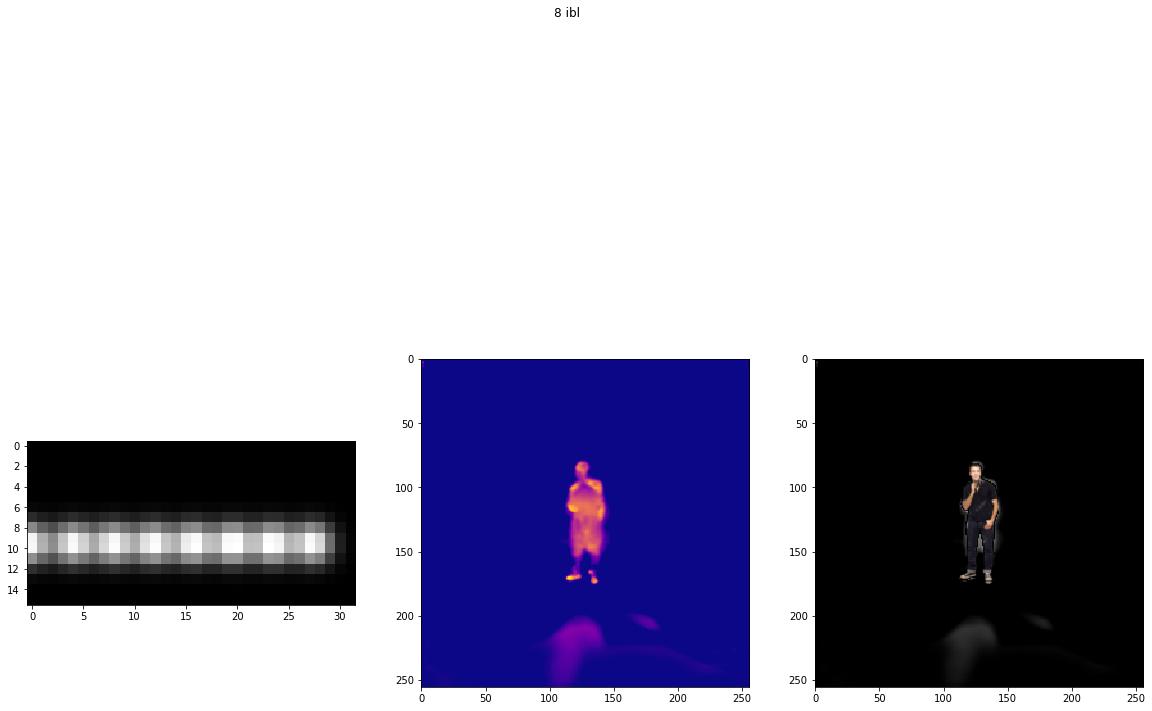

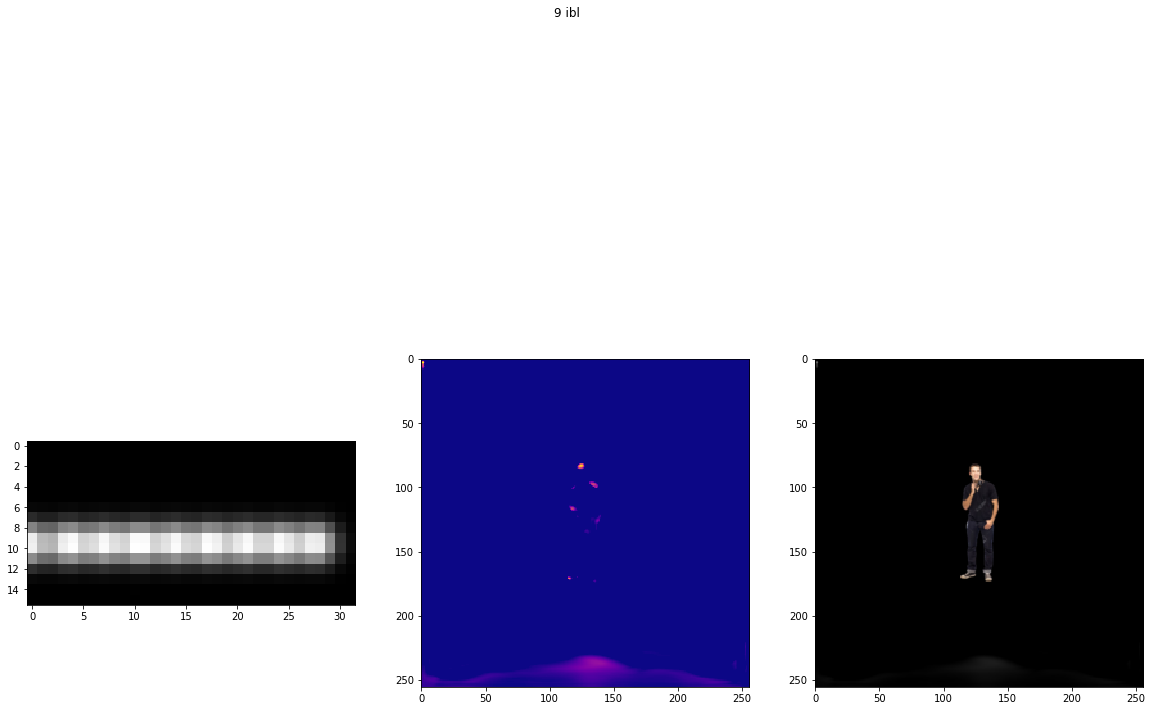

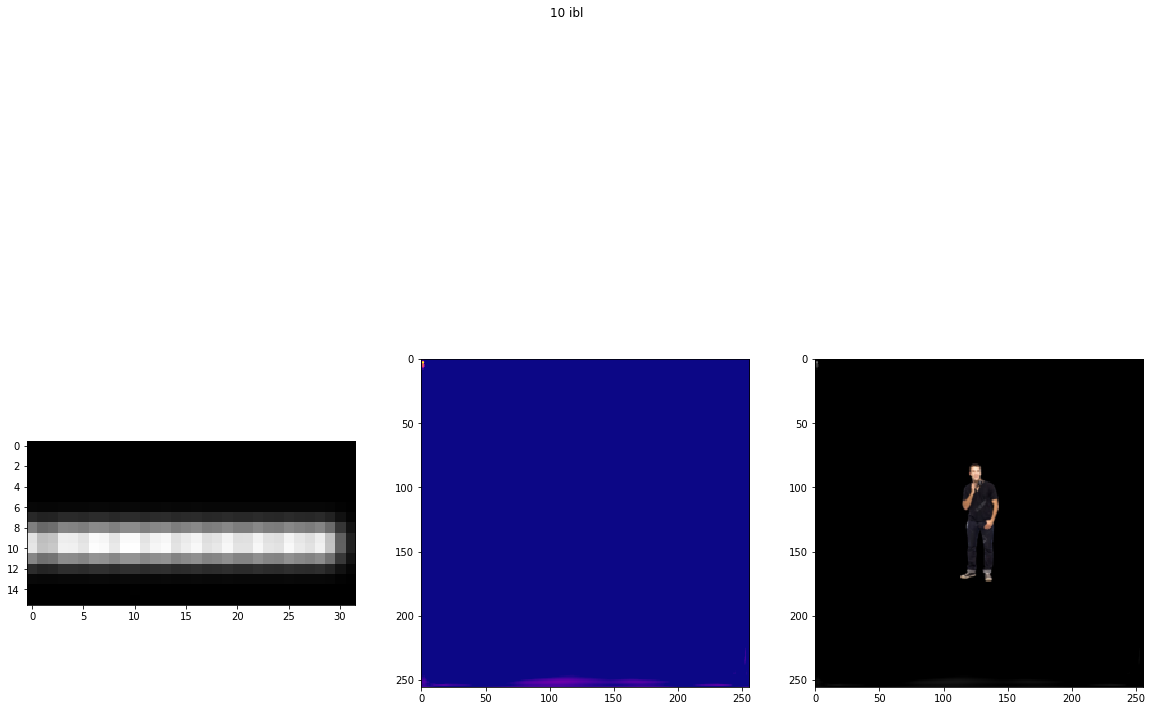

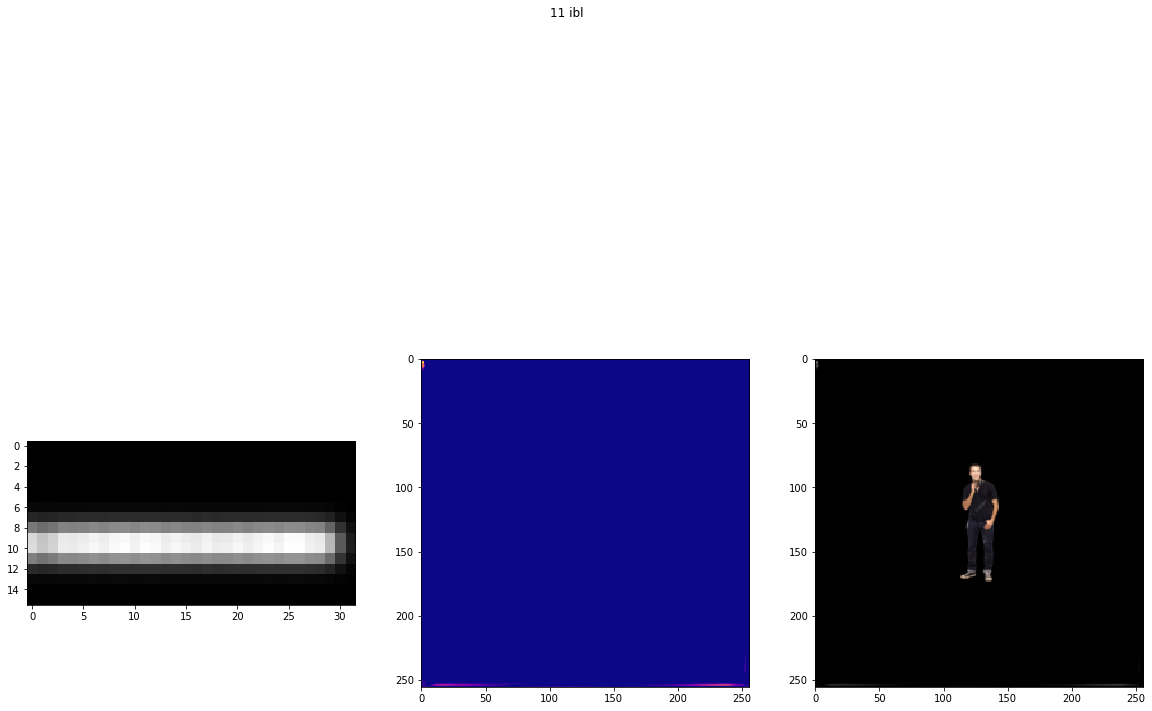

In [181]:
experiment_folder = os.path.join(experiment_path,'even_multiple_ibl')
os.makedirs(experiment_folder, exist_ok=True)

ibl_row_begin, ibl_row_end = 160, 190
ibl_col = 512

max_ibl = 12
num_random_ibl_list = range(1, max_ibl)

for i in tqdm(num_random_ibl_list):    
#     random_rows = np.random.randint(ibl_row_begin, ibl_row_end, size=i)
#     random_cols = np.random.randint(0, 512, size=i)
    step_size = (512-10) // i
    random_cols = range(10, 512, step_size)
    random_rows = [ibl_row_begin] * i
    
    test_ibl = compute_ibl(random_cols[0], random_rows[0])
    for j in range(1, i):
        test_ibl += compute_ibl(random_cols[j], random_rows[j])
    
    h,w = test_ibl.shape
    test_ibl = np.reshape(test_ibl, (h,w,1))
    
    predicted_img = predict(testing_mask, test_ibl)/i
    title = '{} ibl'.format(i)
    merged = merge_result(testing_img, predicted_img)

#     print(np.min(predicted_img), np.max(predicted_img))
#     print(np.min(testing_img), np.max(testing_img))
    
    save_path = os.path.join(experiment_folder, title + '.pdf')
    plot_result(test_ibl, predicted_img, testing_img, title, save_path)

## Bigger Gaussion








  0%|          | 0/3 [00:00<?, ?it/s]

0.0 1.0


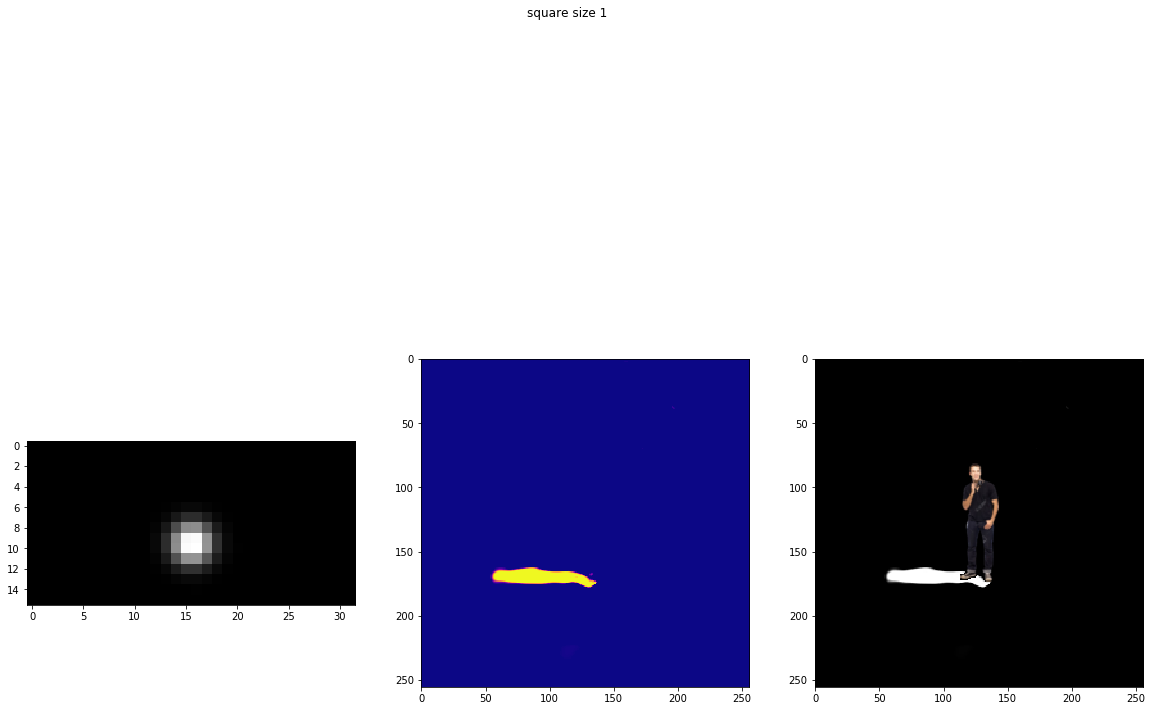

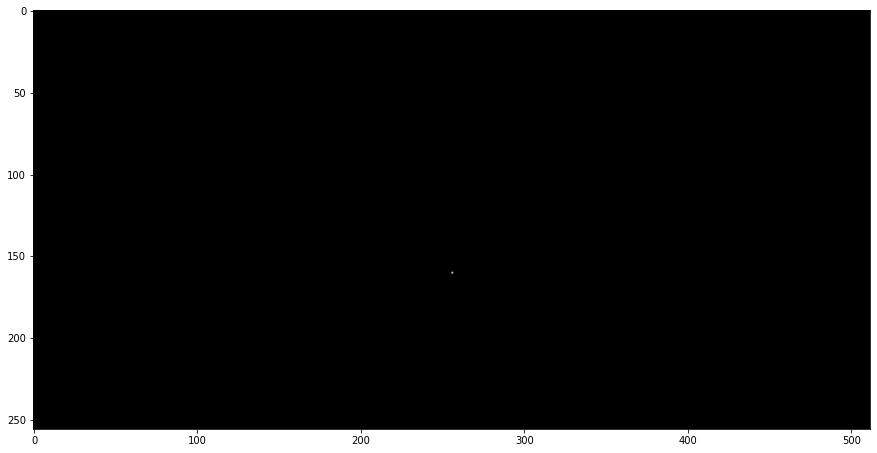








 33%|███▎      | 1/3 [00:03<00:06,  3.33s/it]

0.0 1.0


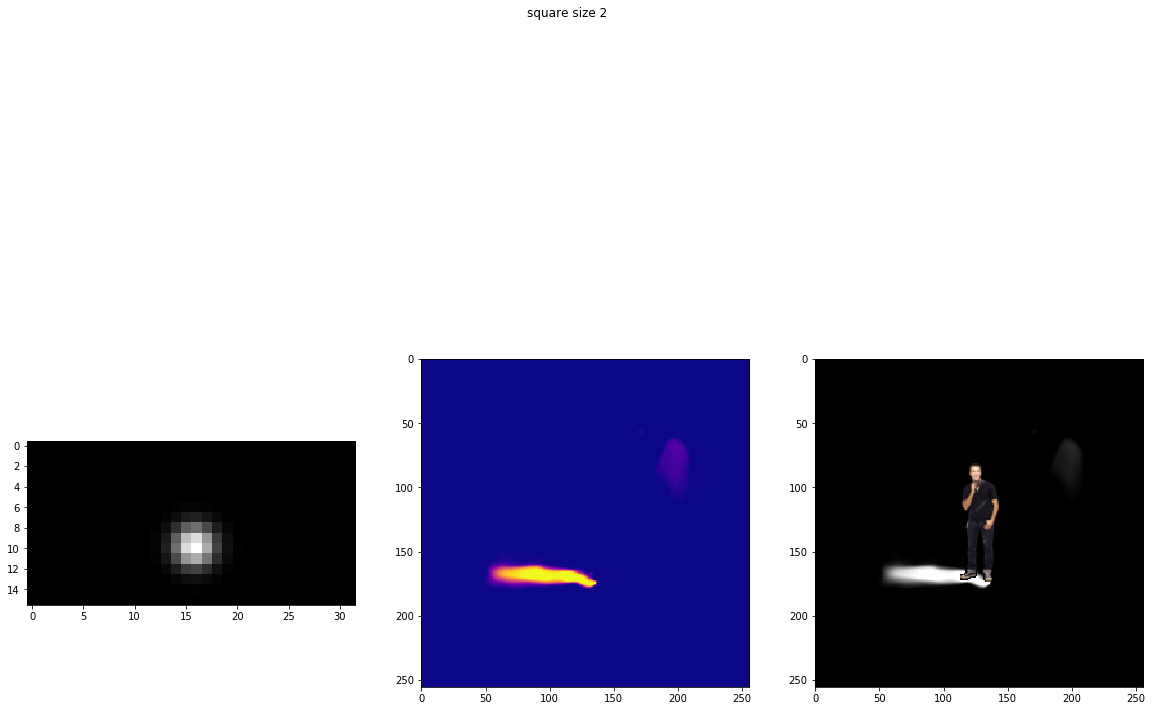

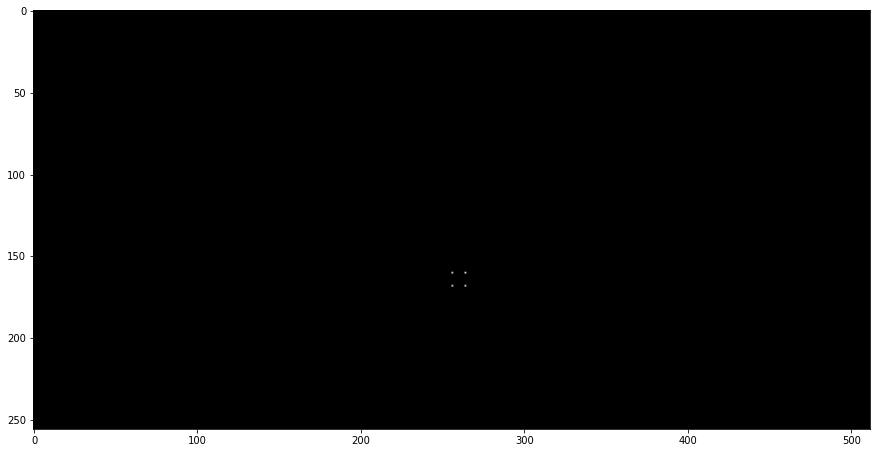








 67%|██████▋   | 2/3 [00:07<00:03,  3.54s/it]

0.0 0.4603405


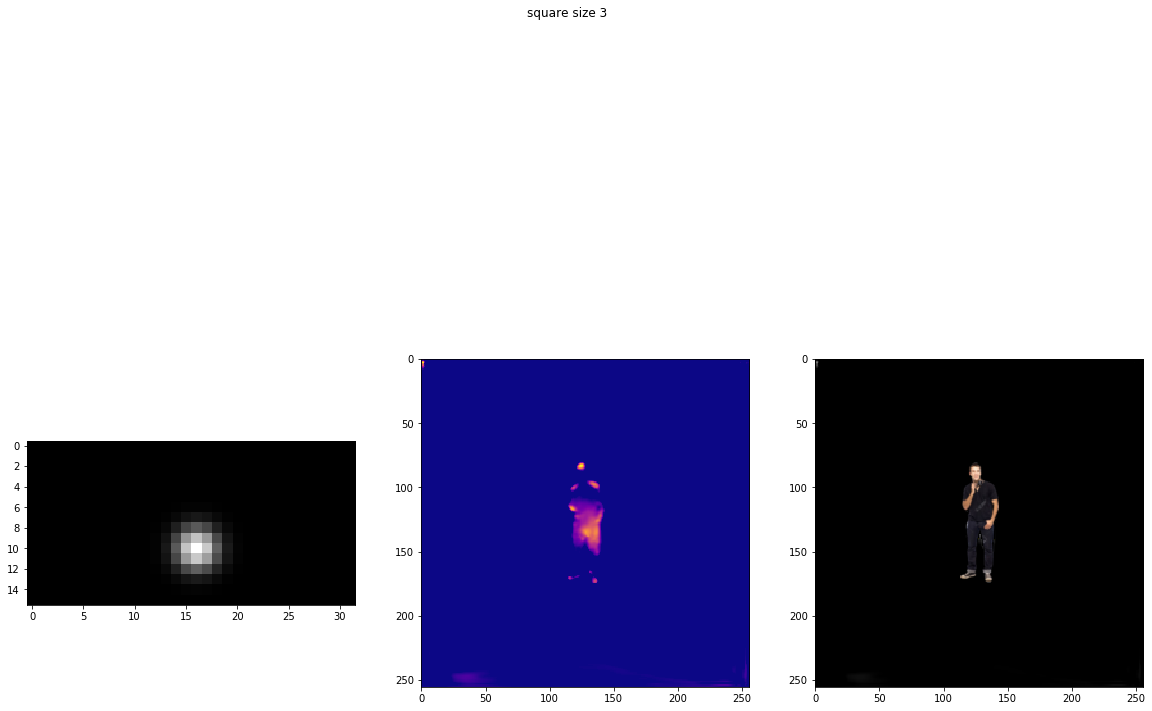

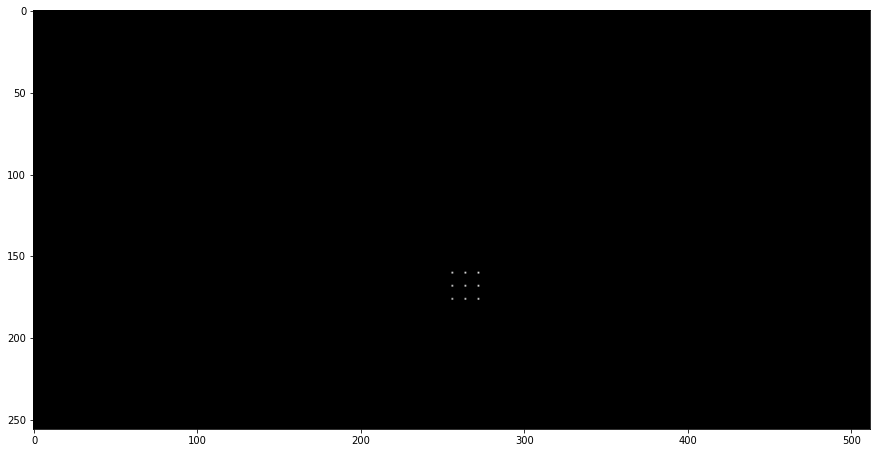








100%|██████████| 3/3 [00:11<00:00,  3.74s/it]


In [192]:
import random
experiment_folder = os.path.join(experiment_path,'bigger_radius')
os.makedirs(experiment_folder, exist_ok=True)

step_size = (256 // 16)//2 
max_size = 3

random.seed(19920208)

def compute_ori_ibl(i,j,w=512, h=256):
    ibl = np.zeros((h,w,1))
    ibl[j,i] = 1.0
    return ibl

begin_i, begin_j = 256, 160
for i in tqdm(range(max_size)):   
    ibl_ori = compute_ori_ibl(begin_i, begin_j)
    test_ibl = compute_ibl(begin_i, begin_j)
    
    for x in range(i+1):
        for y in range(i+1):
            if x == 0 and y == 0:
                continue
            
            test_ibl += compute_ibl(begin_i + x * step_size, begin_j + y * step_size)
            ibl_ori += compute_ori_ibl(begin_i + x * step_size, begin_j + y * step_size)
    
    h,w = test_ibl.shape
    test_ibl = np.reshape(test_ibl, (h,w,1))
    
    predicted_img = predict(testing_mask, test_ibl)/((i+1)* (i+1))
    # clipping 
    np.clip(predicted_img, 0.0, 1.0, out=predicted_img)
    
    title = 'square size {}'.format(i + 1)
    merged = merge_result(testing_img, predicted_img)
    
    print(np.min(predicted_img), np.max(predicted_img))
    
    save_path = os.path.join(experiment_folder, title + '.pdf')
    plot_result(test_ibl, predicted_img, testing_img, title, save_path)
    show_np(ibl_ori)

## Real human 








  0%|          | 0/45 [00:00<?, ?it/s]

human imgs: 45


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).







  2%|▏         | 1/45 [00:01<00:58,  1.32s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).







  4%|▍         | 2/45 [00:02<00:57,  1.35s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).







  7%|▋         | 3/45 [00:03<00:55,  1.32s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).







  9%|▉         | 4/45 [00:05<00:53,  1.30s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).







 11%|█         | 5/45 [00:06<00:55,  1.38s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).







 13%|█▎        | 6/45 [00:08<00:51,  1.33s/it]Clipping input data to

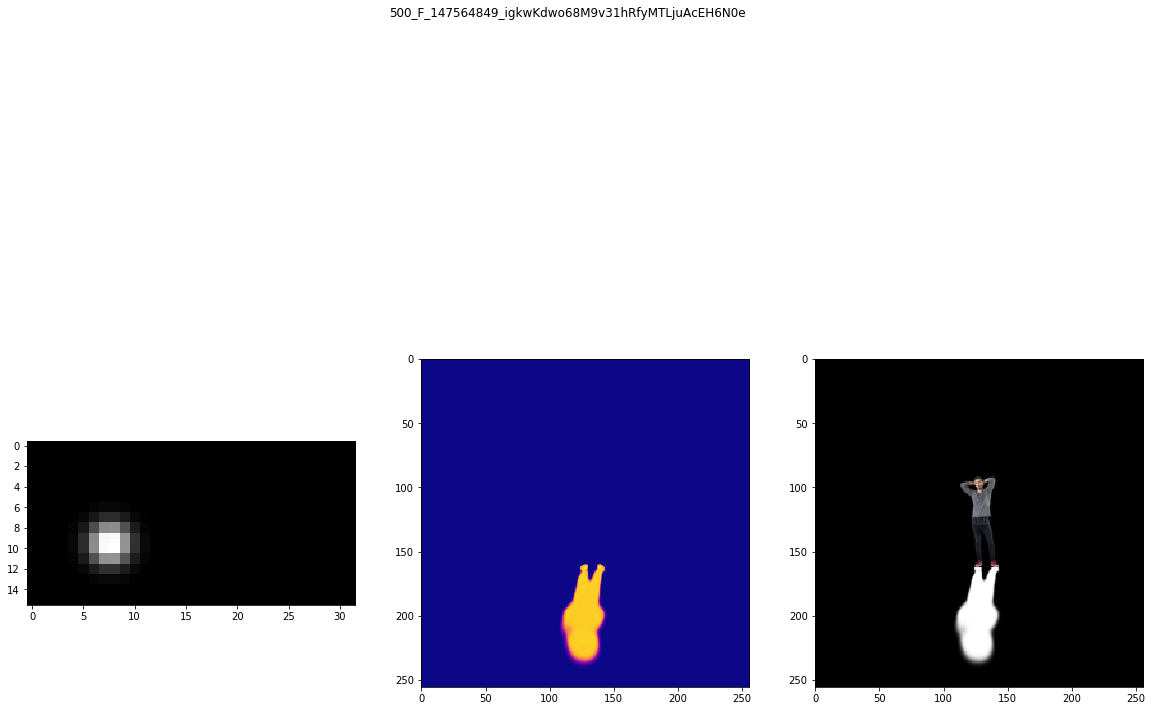

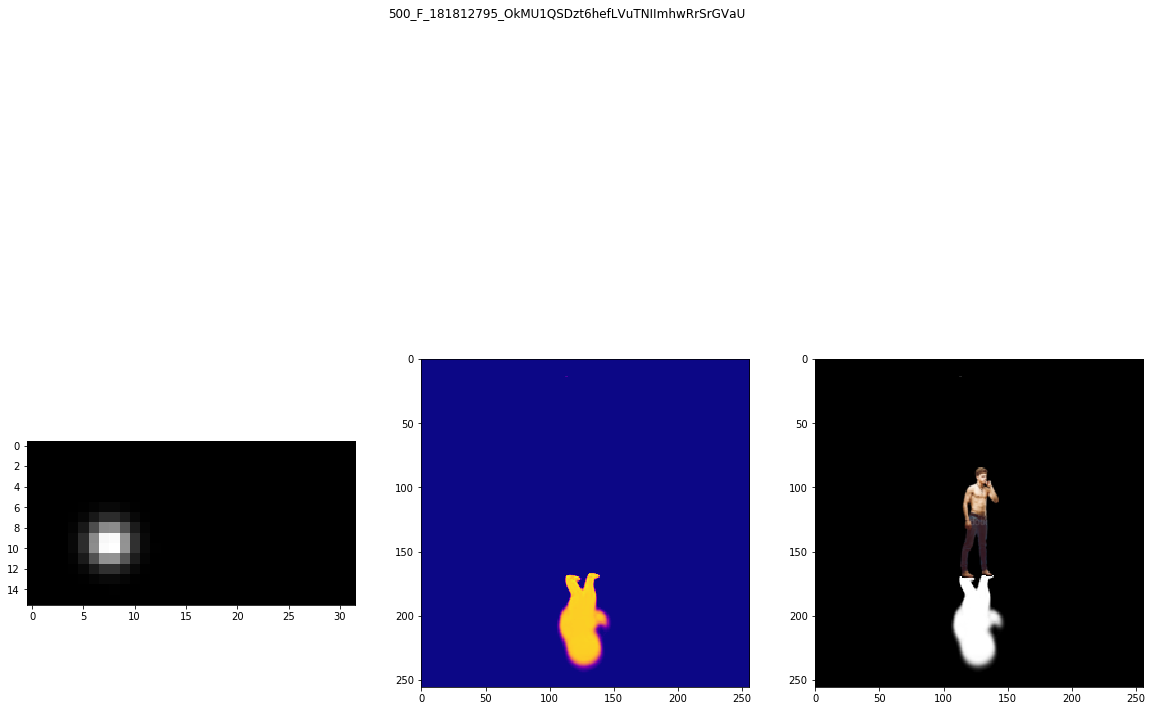

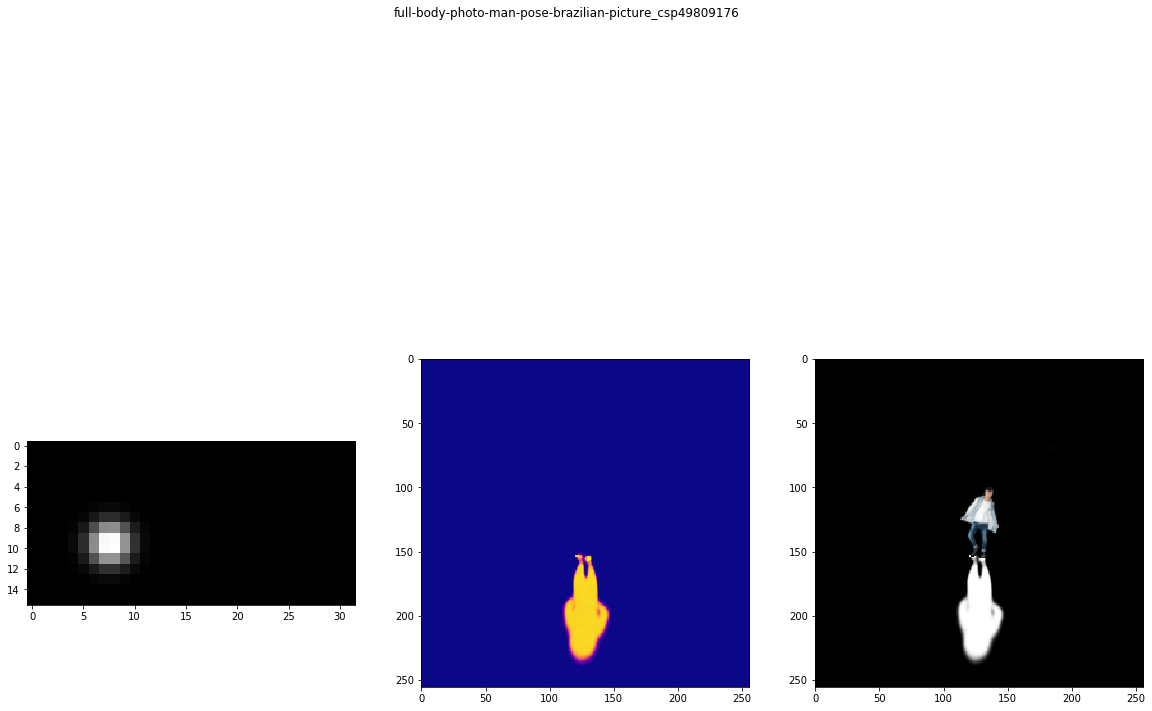

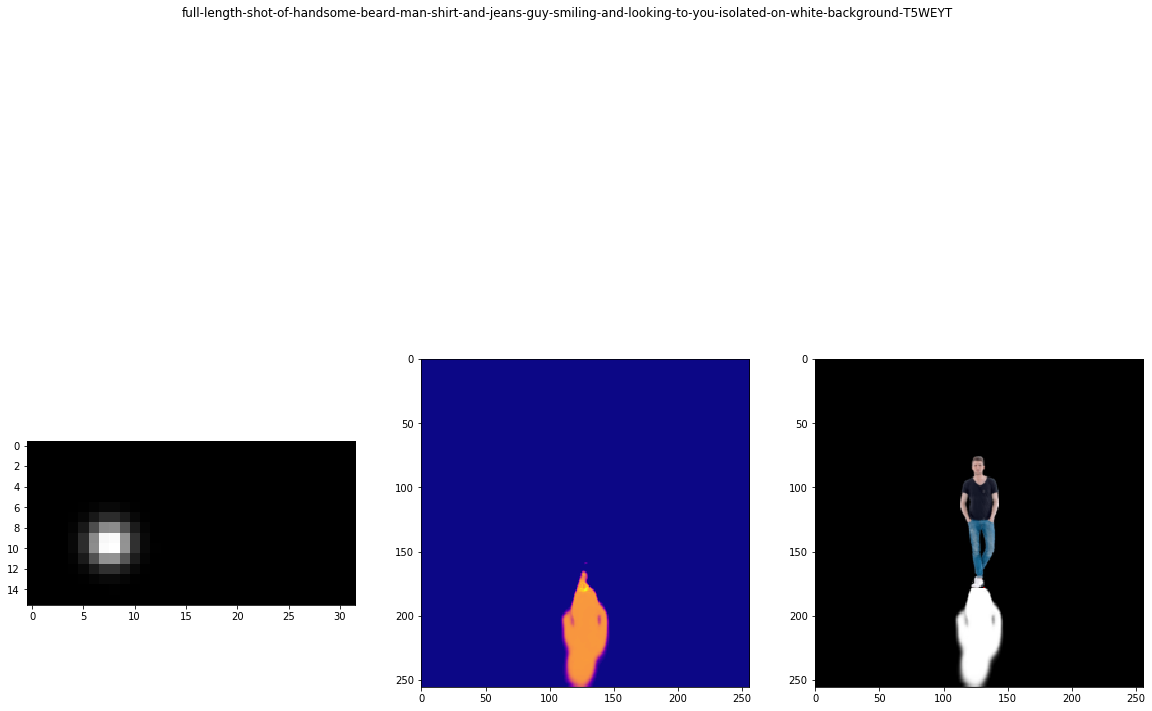

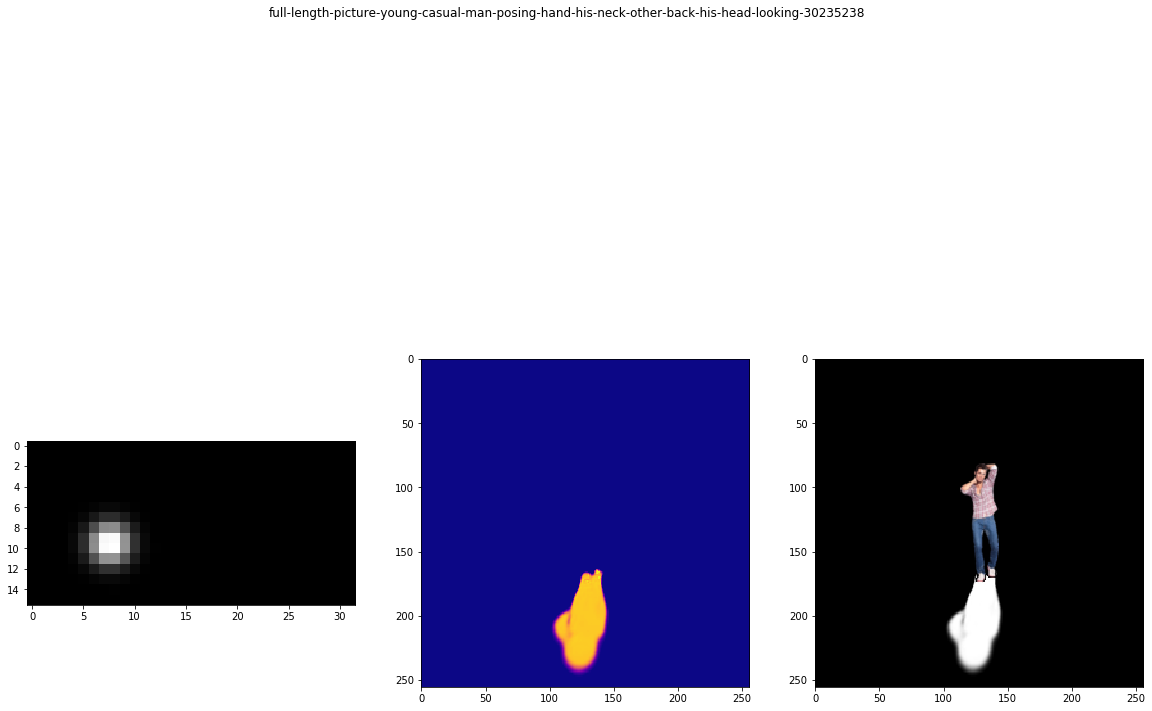

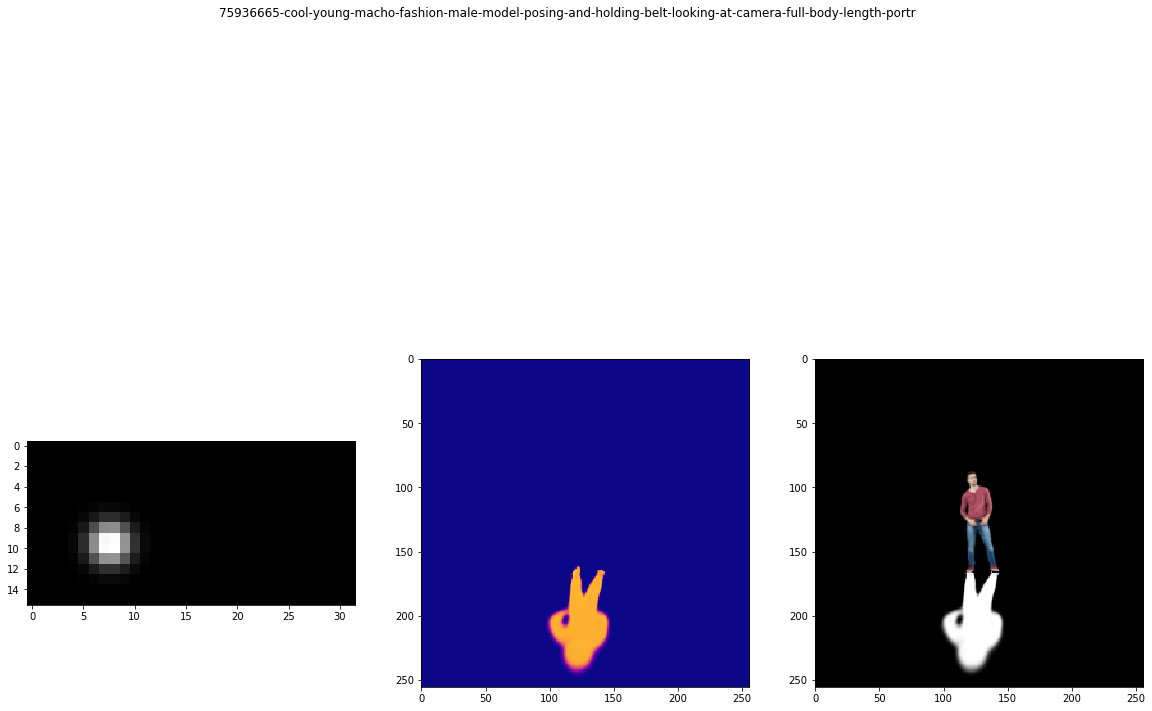

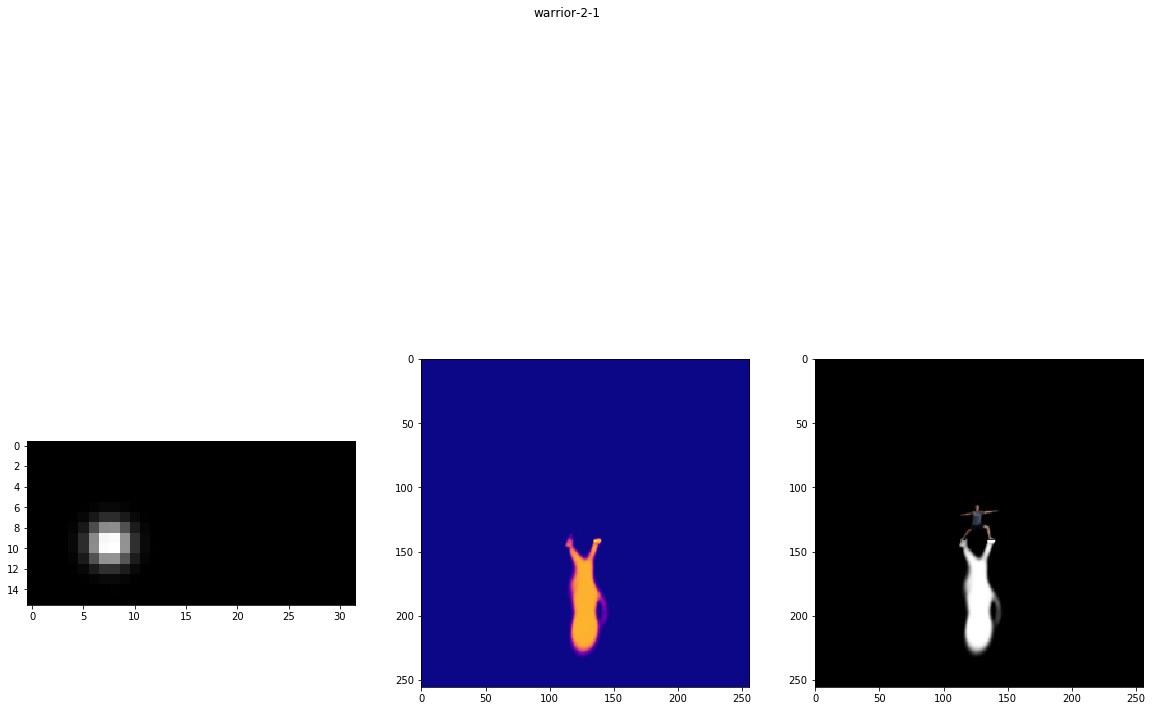

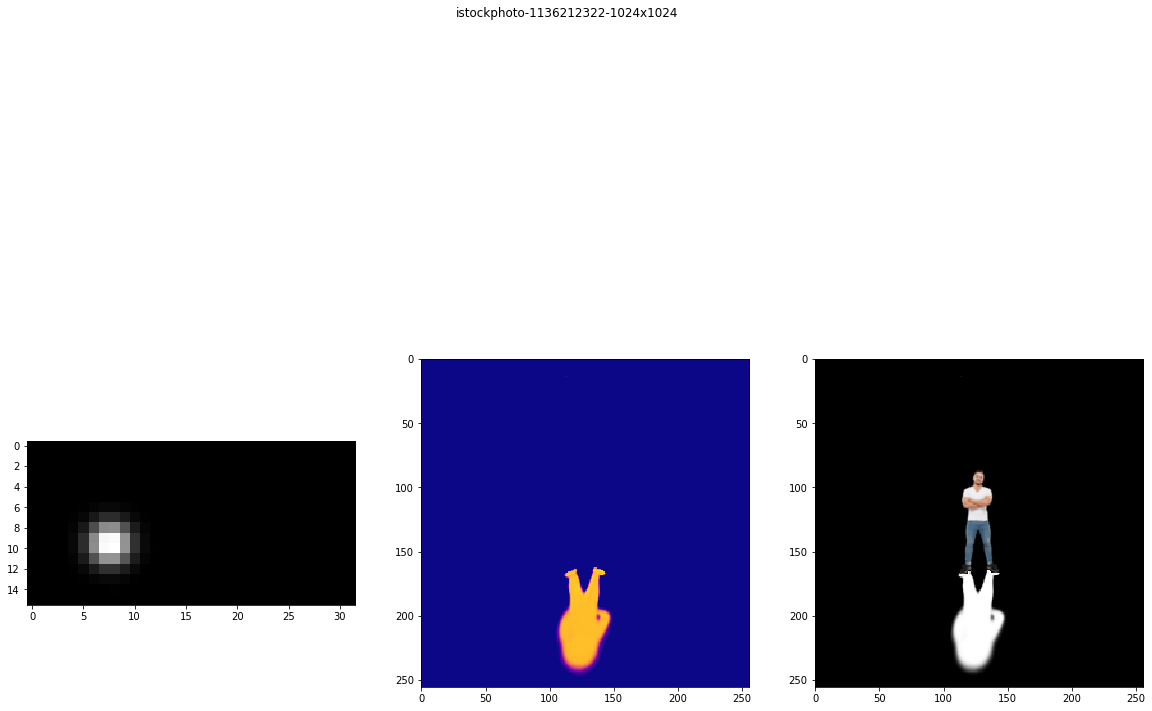

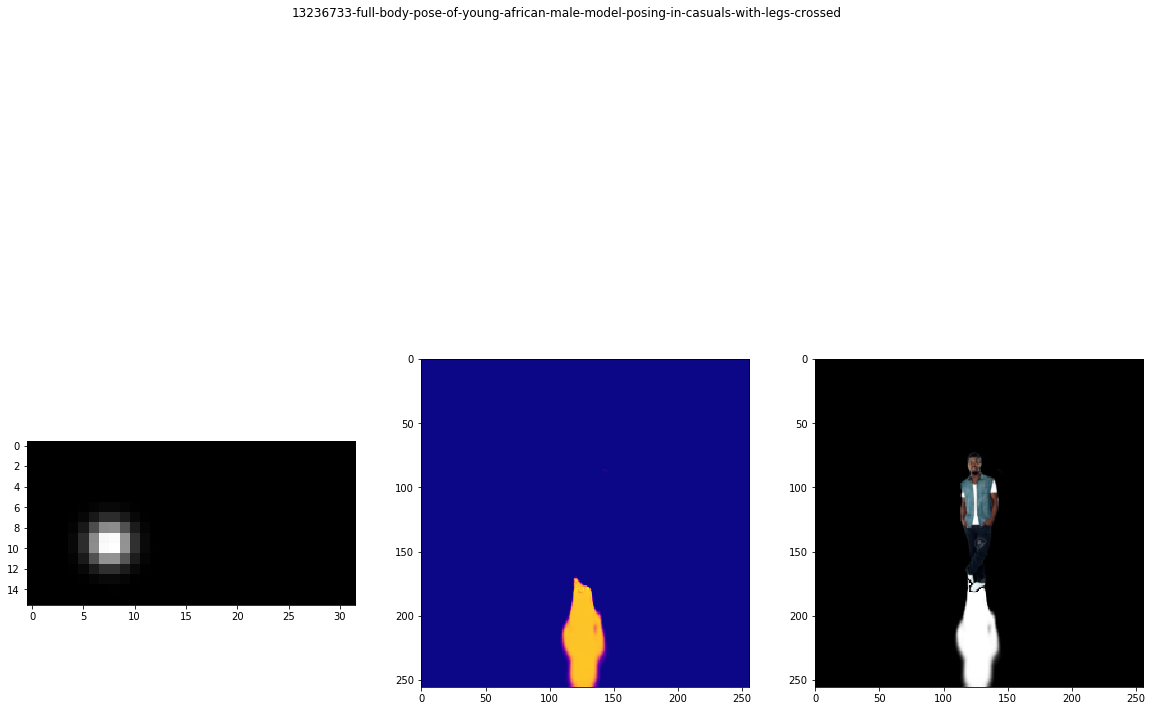

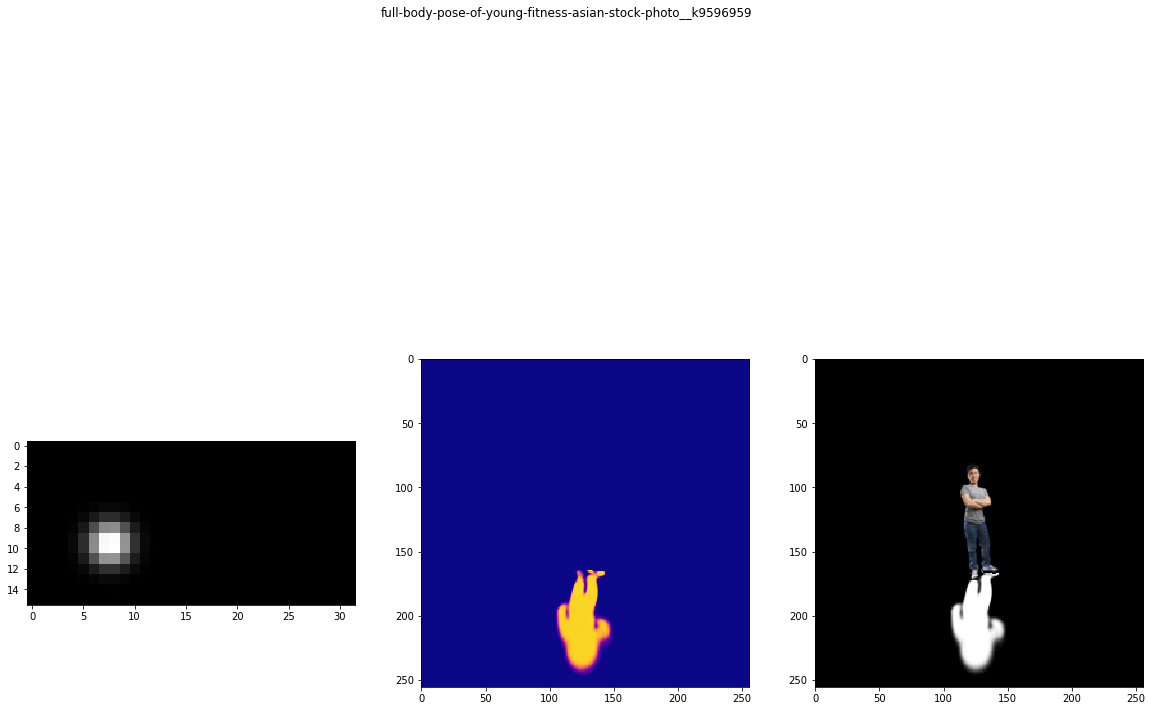

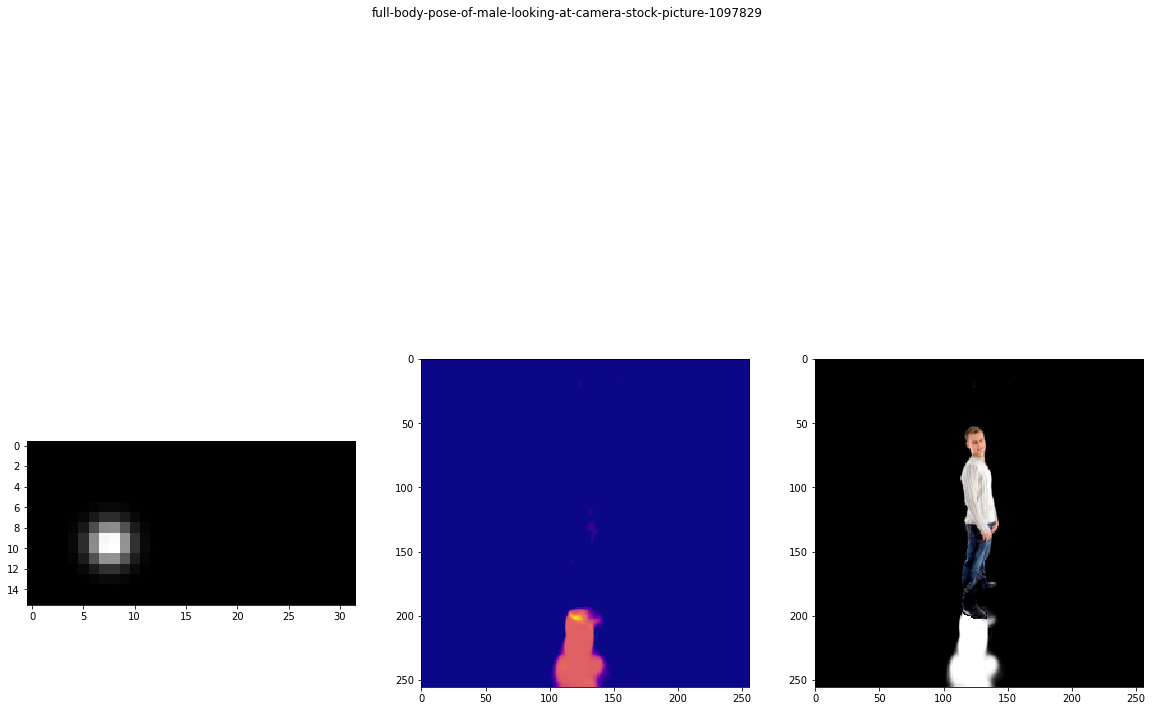

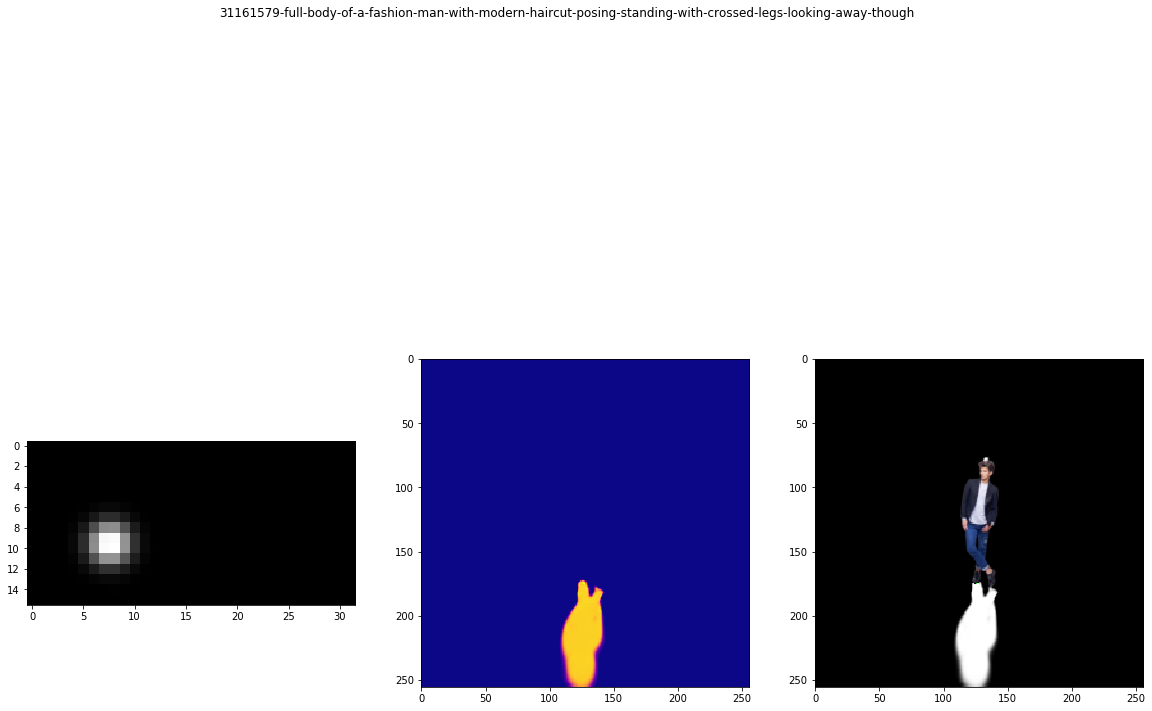

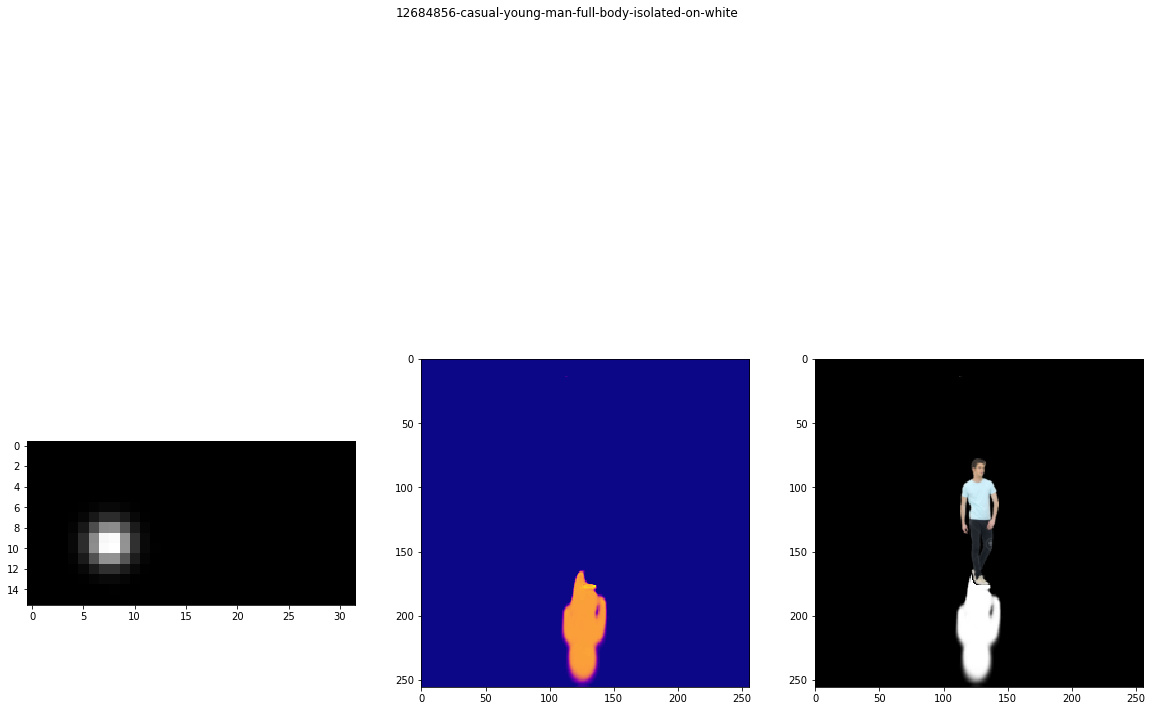

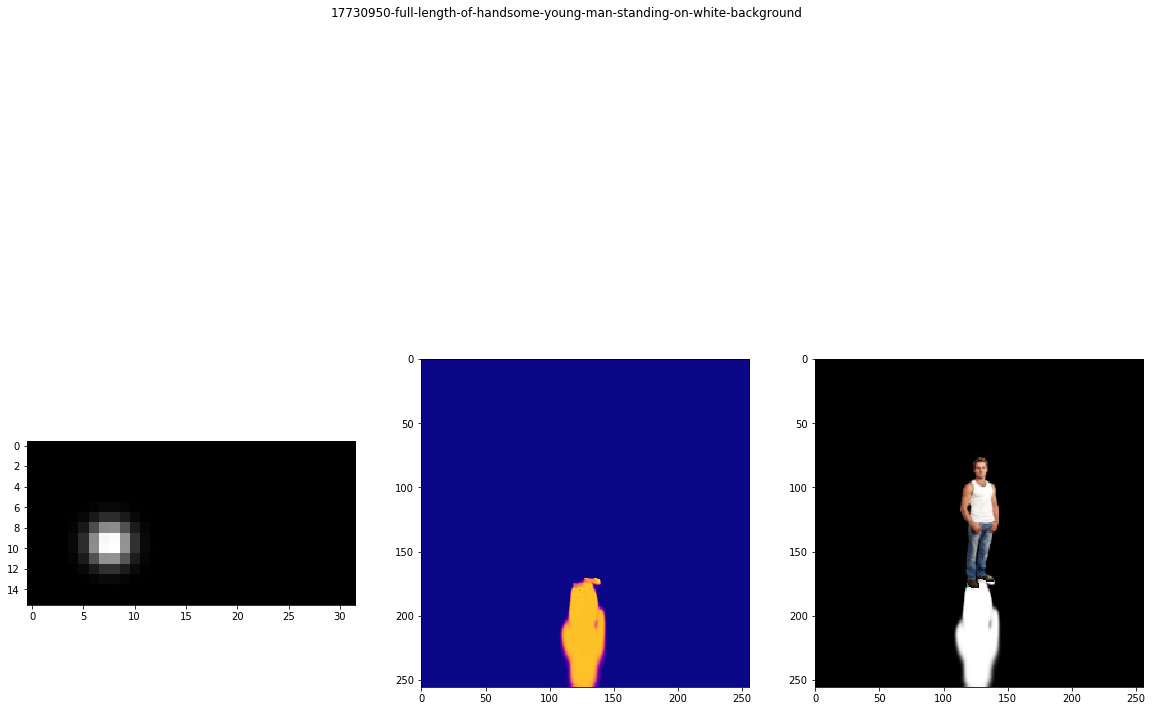

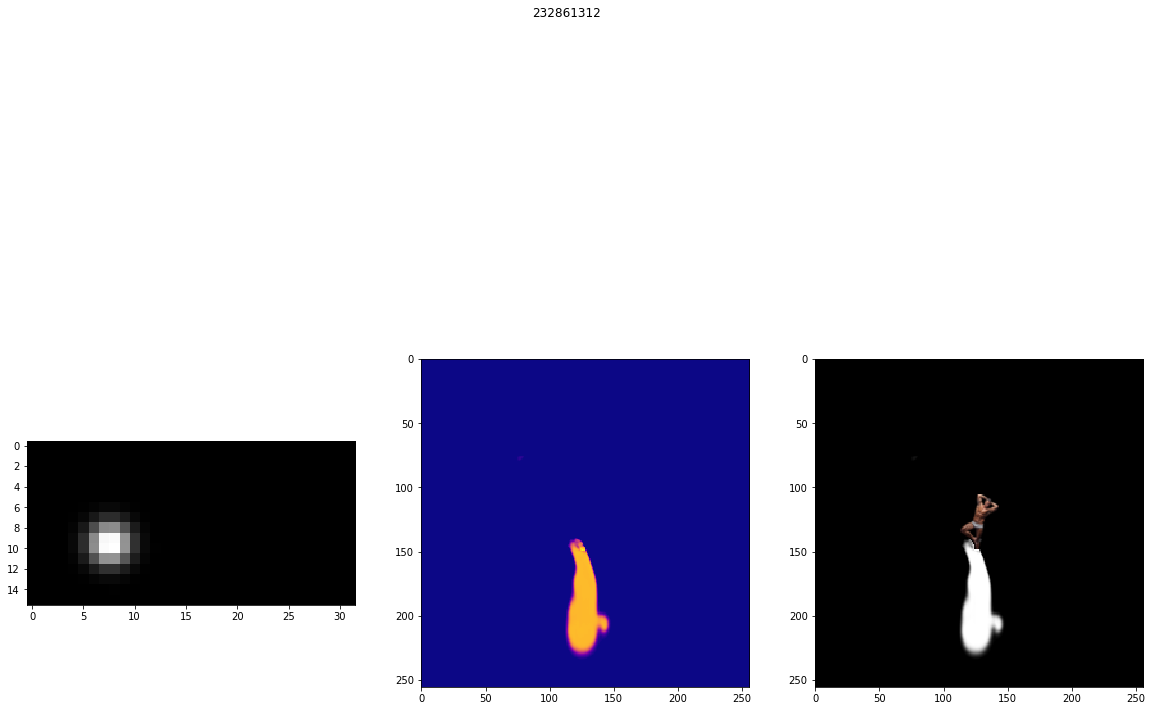

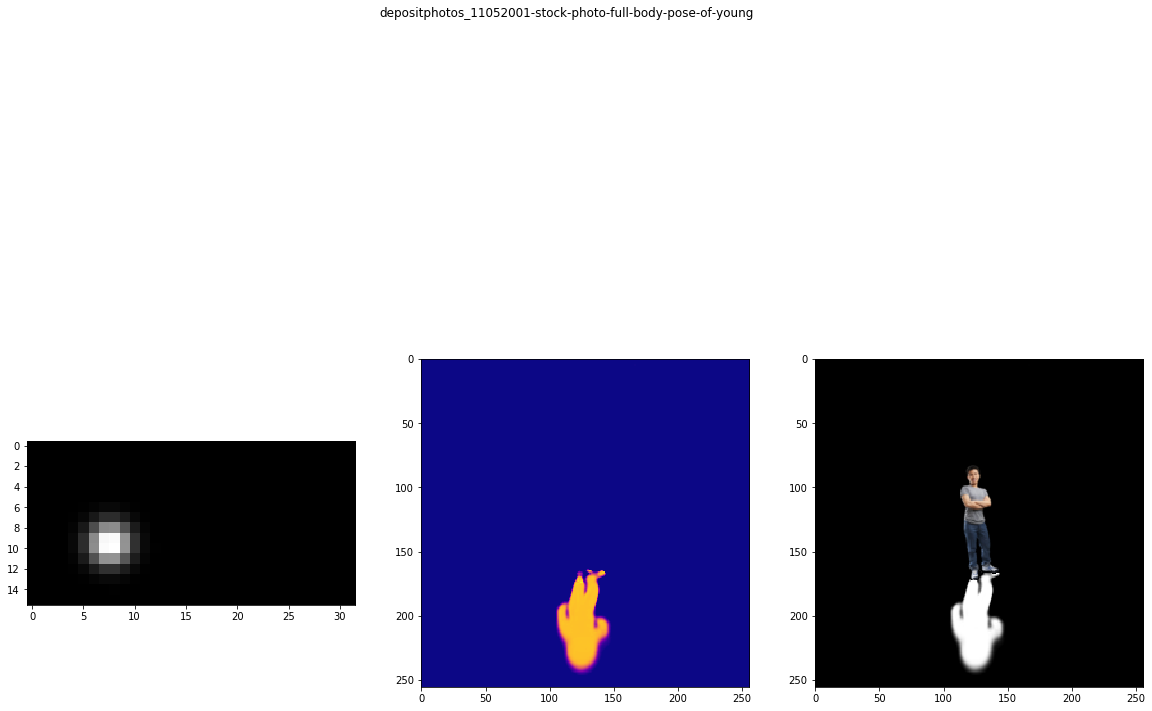

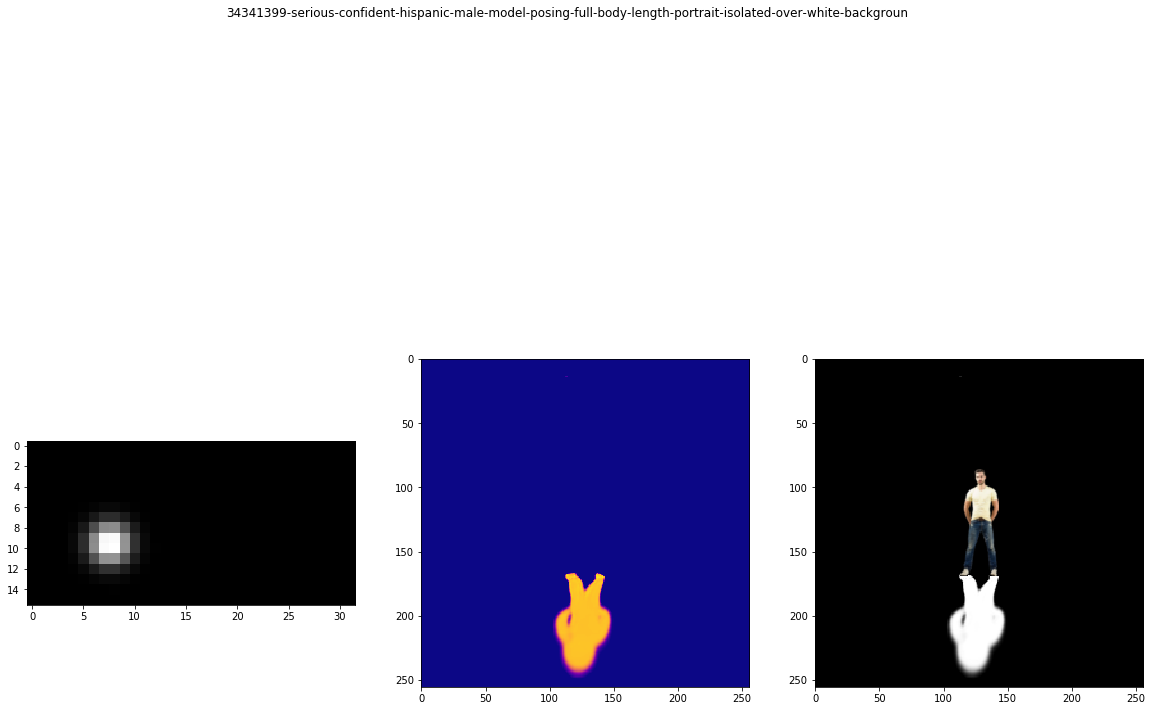

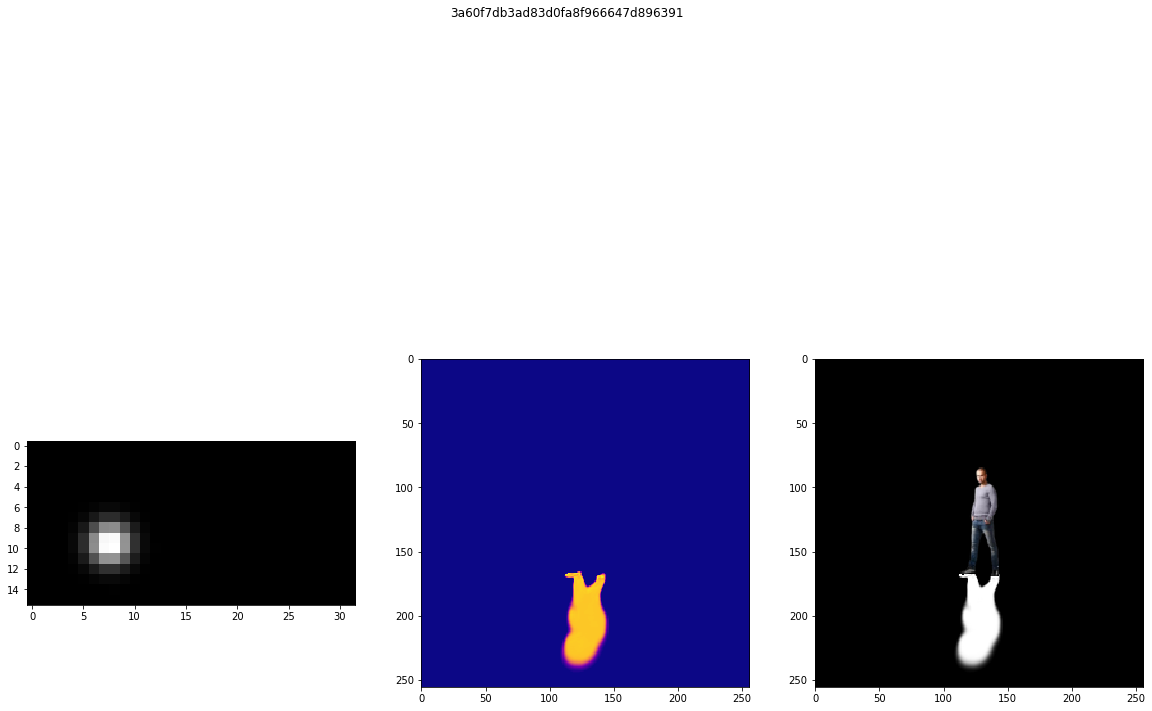

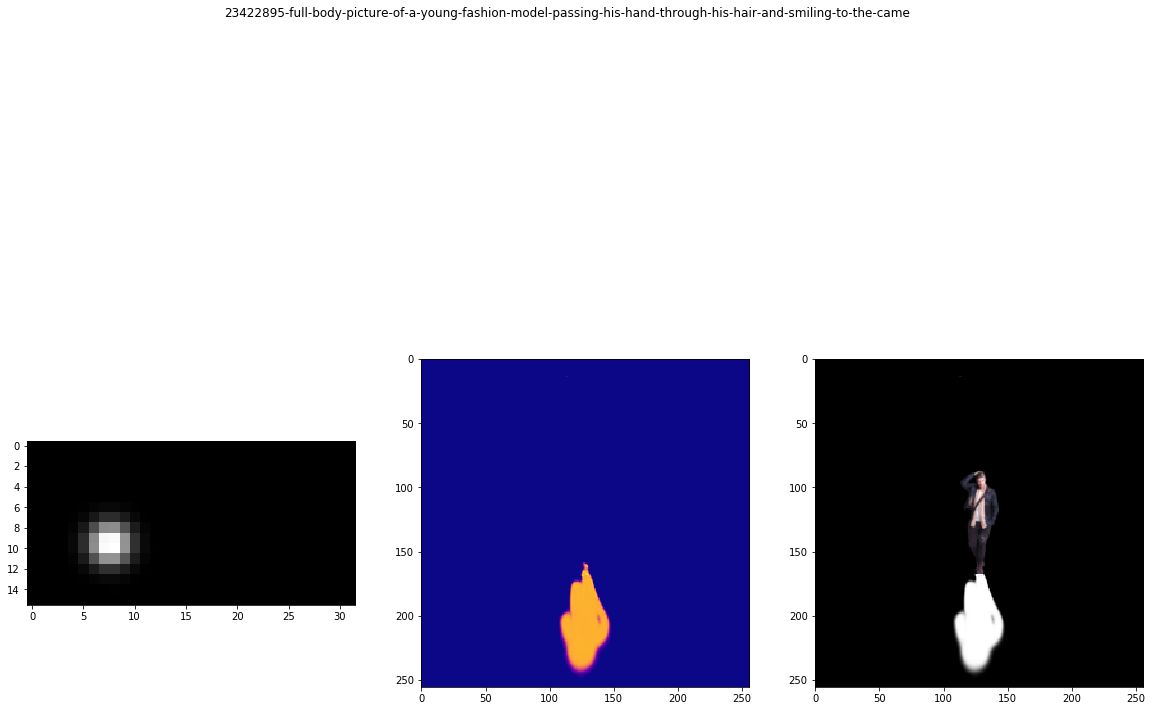

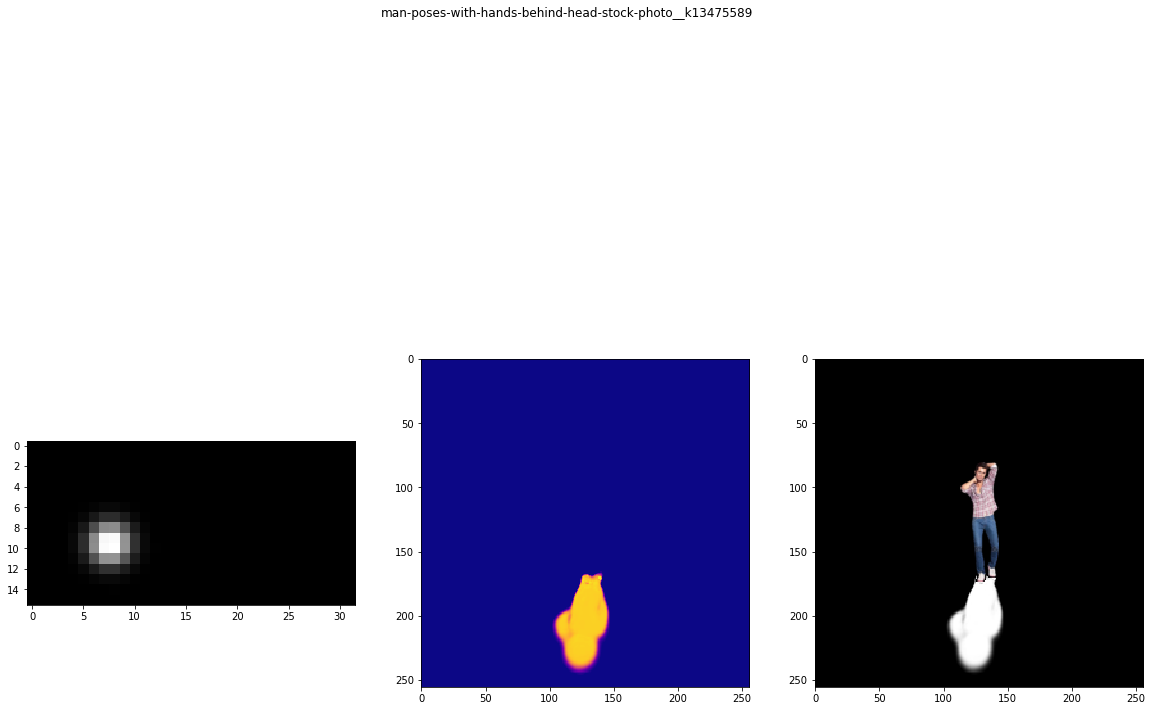

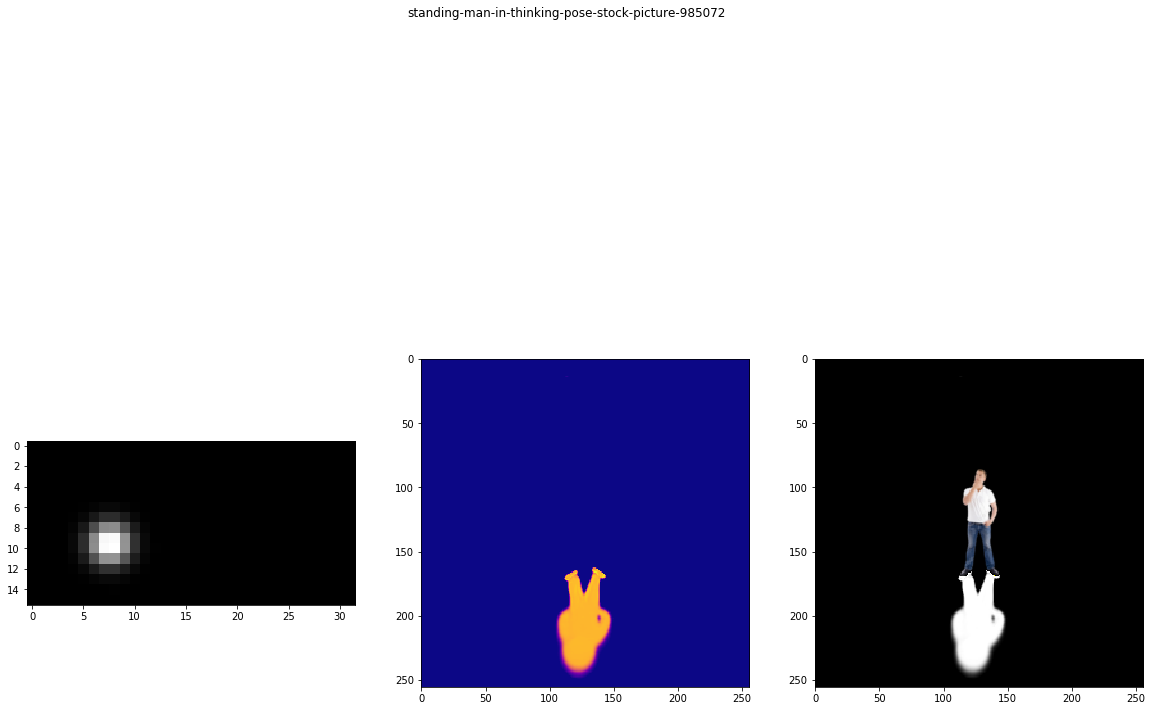

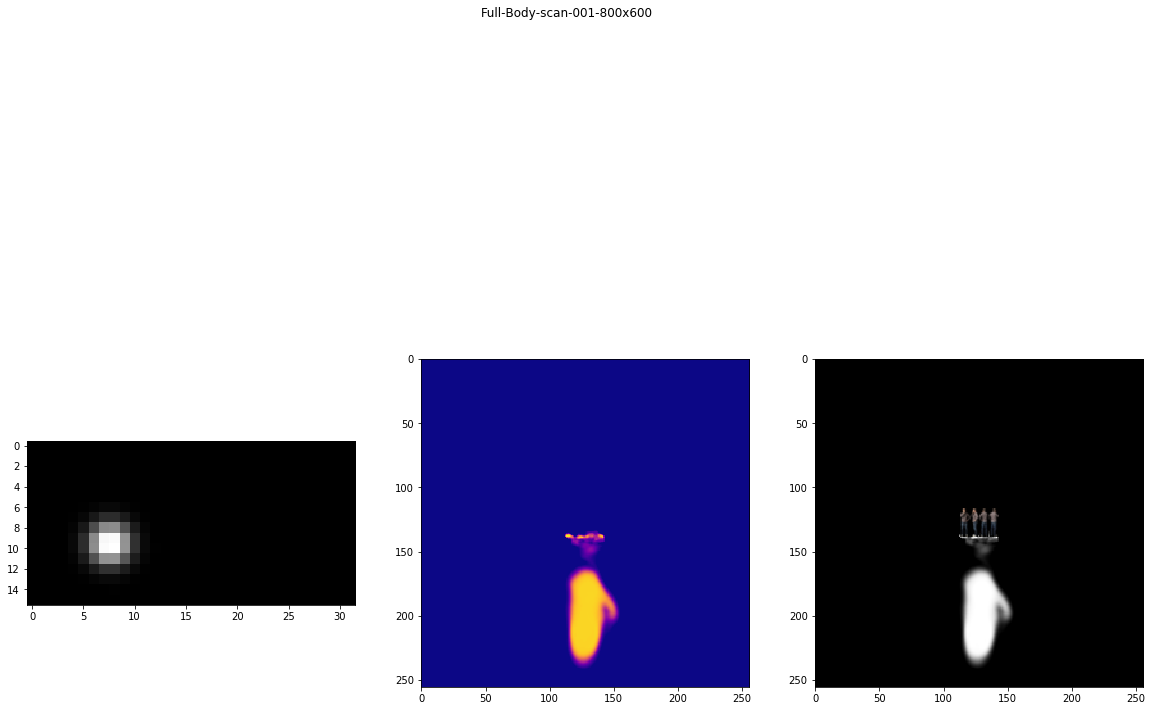

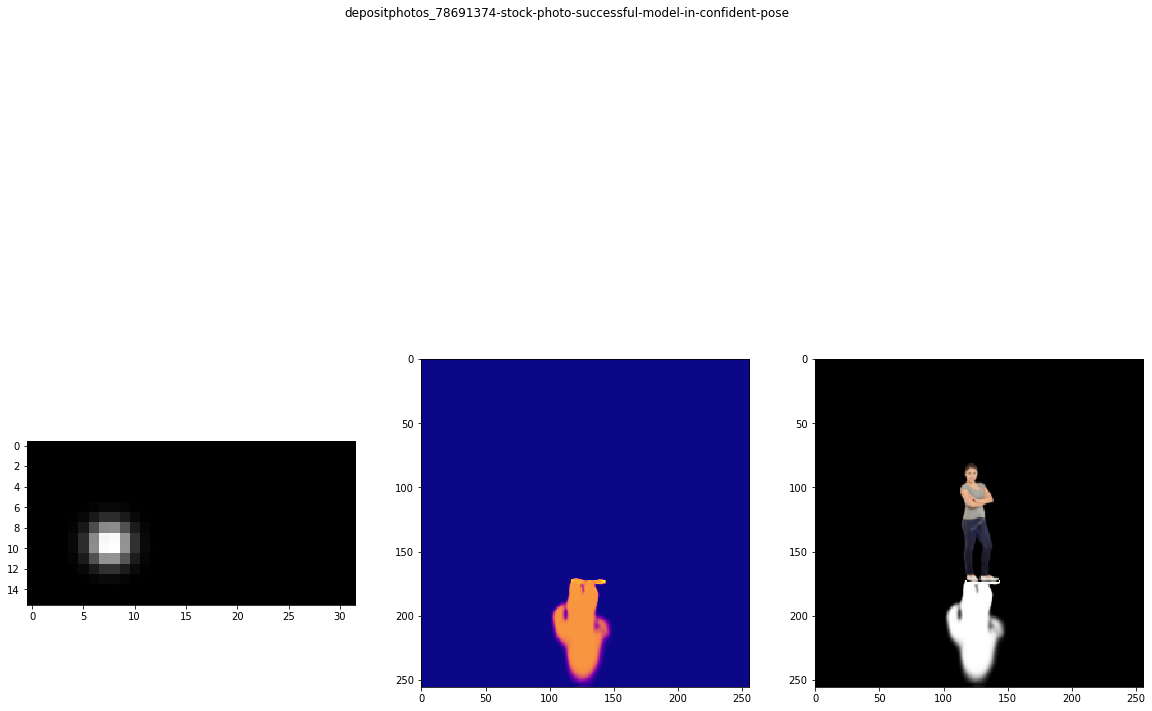

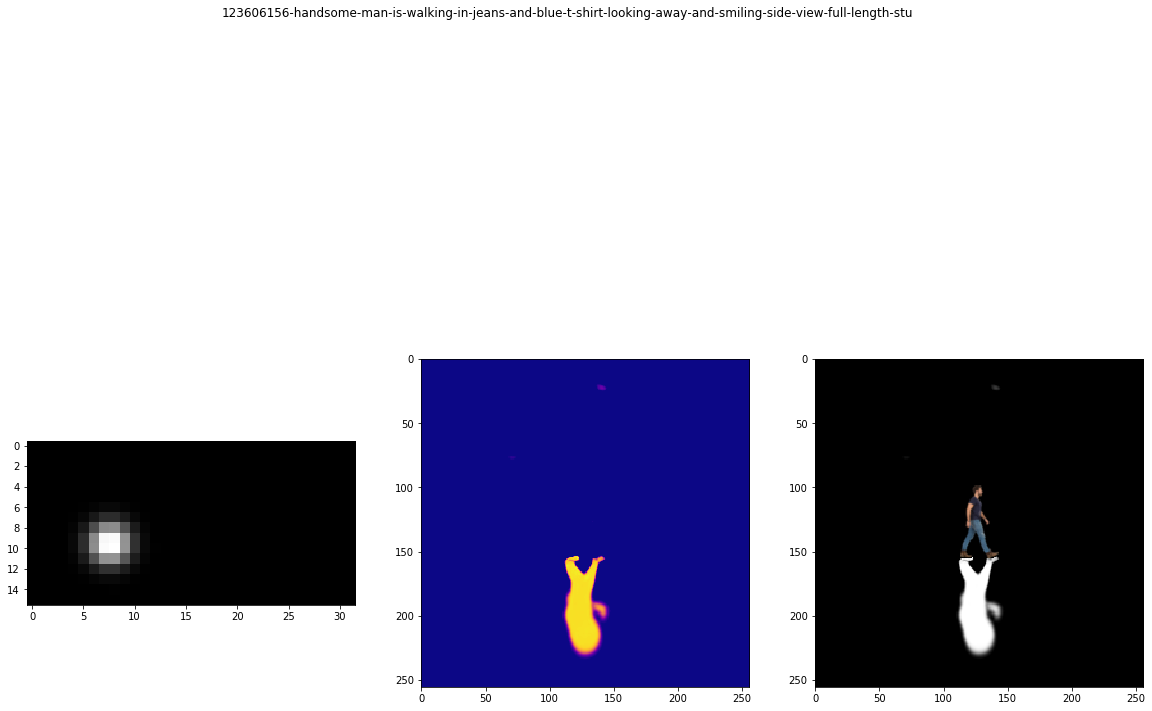

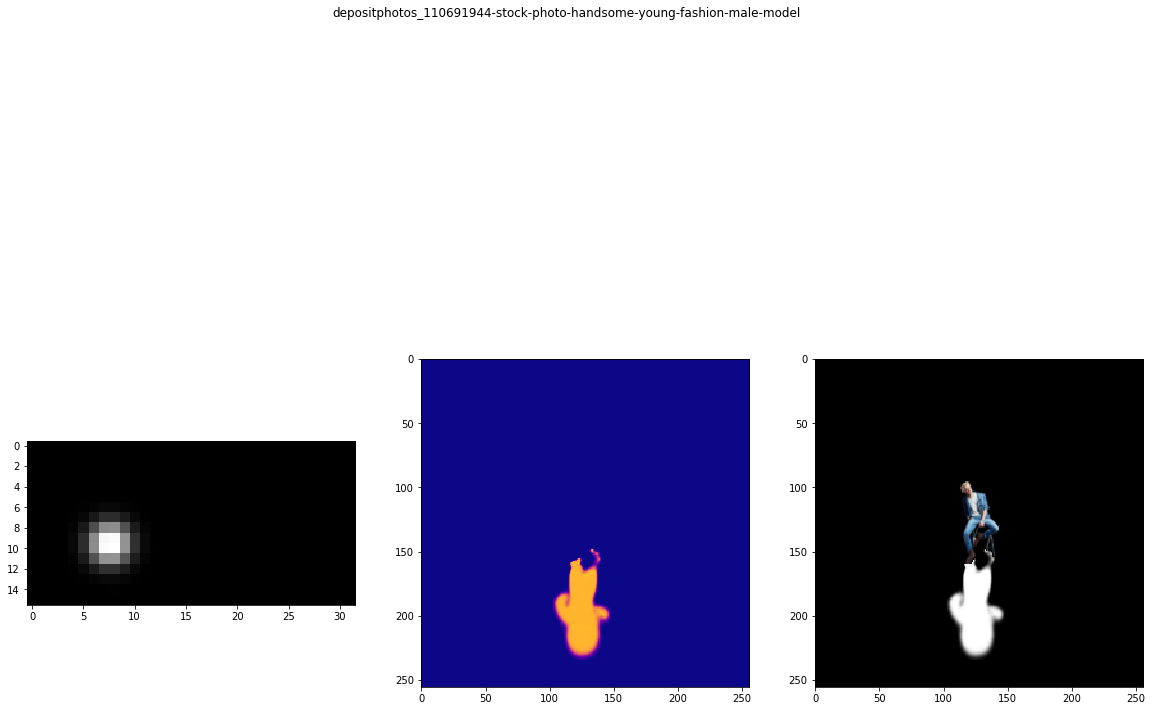

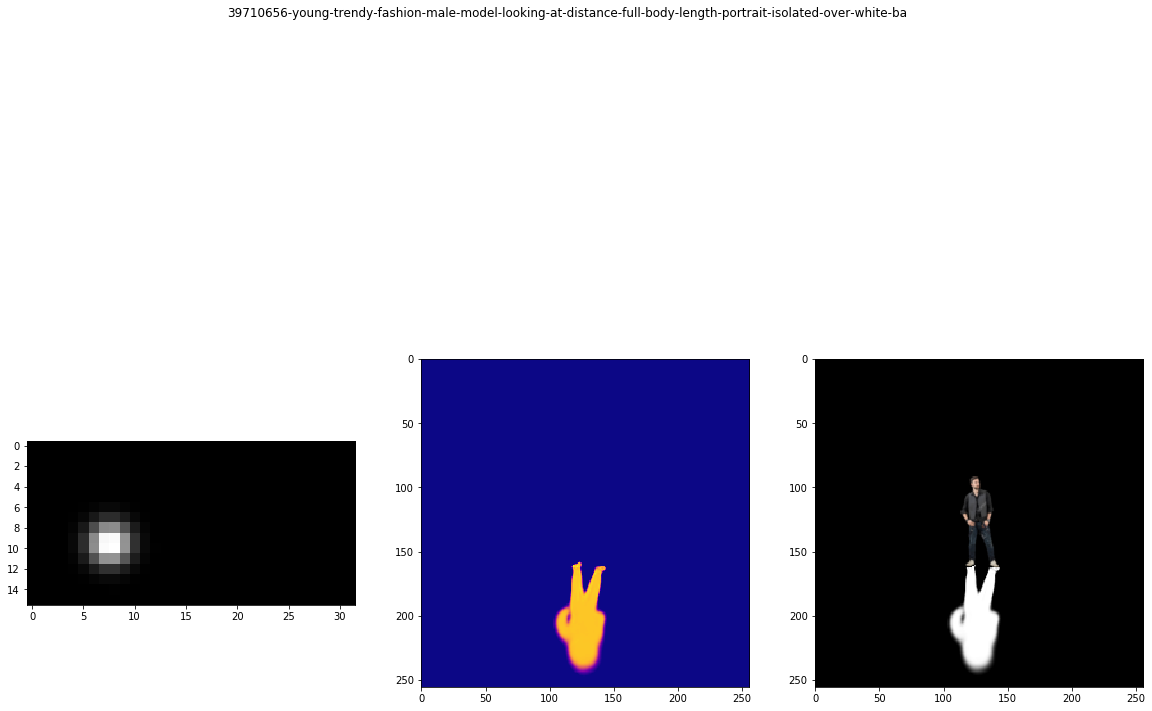

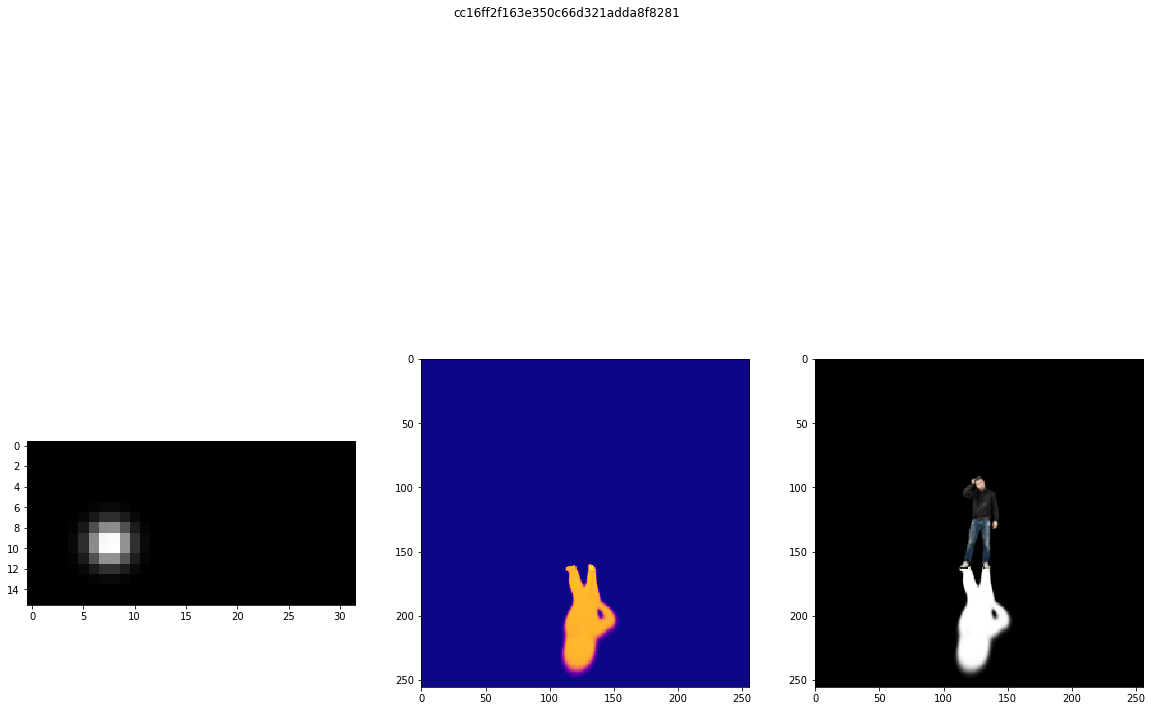

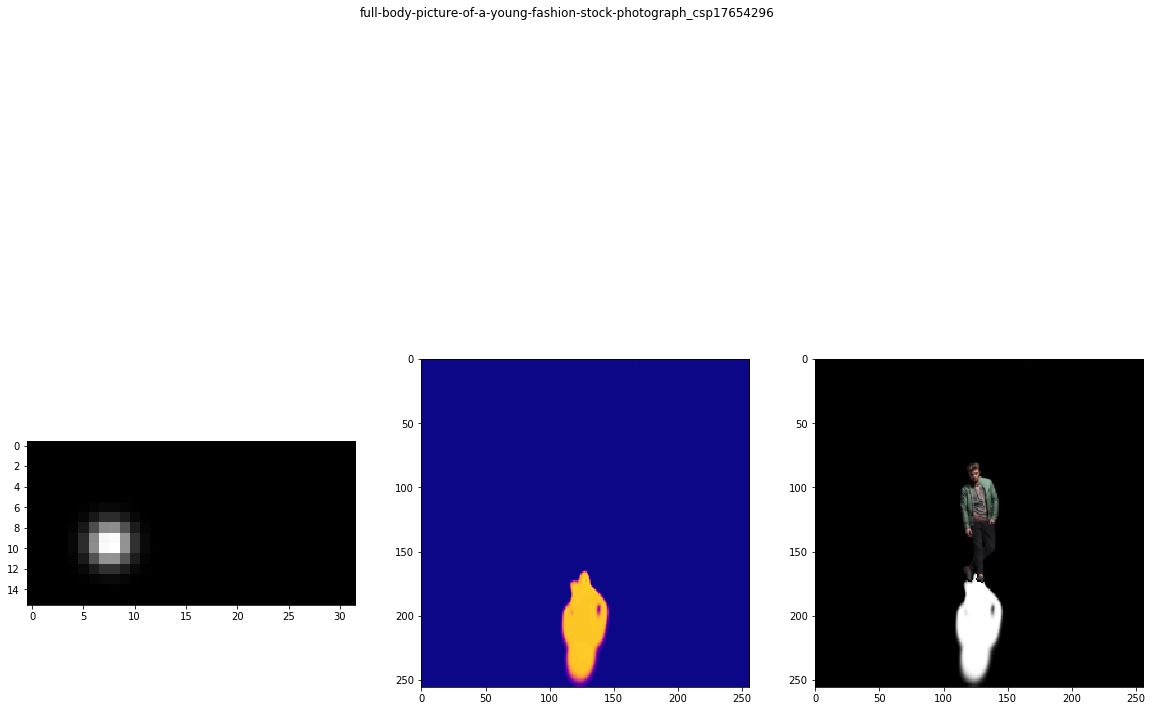

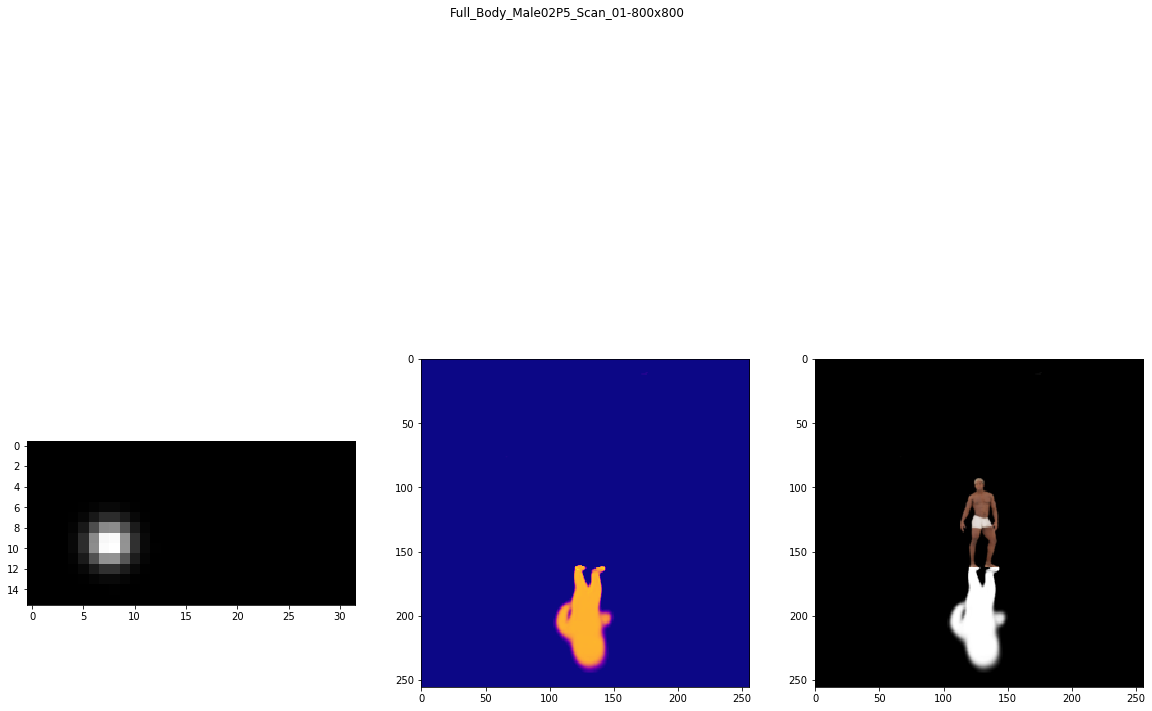

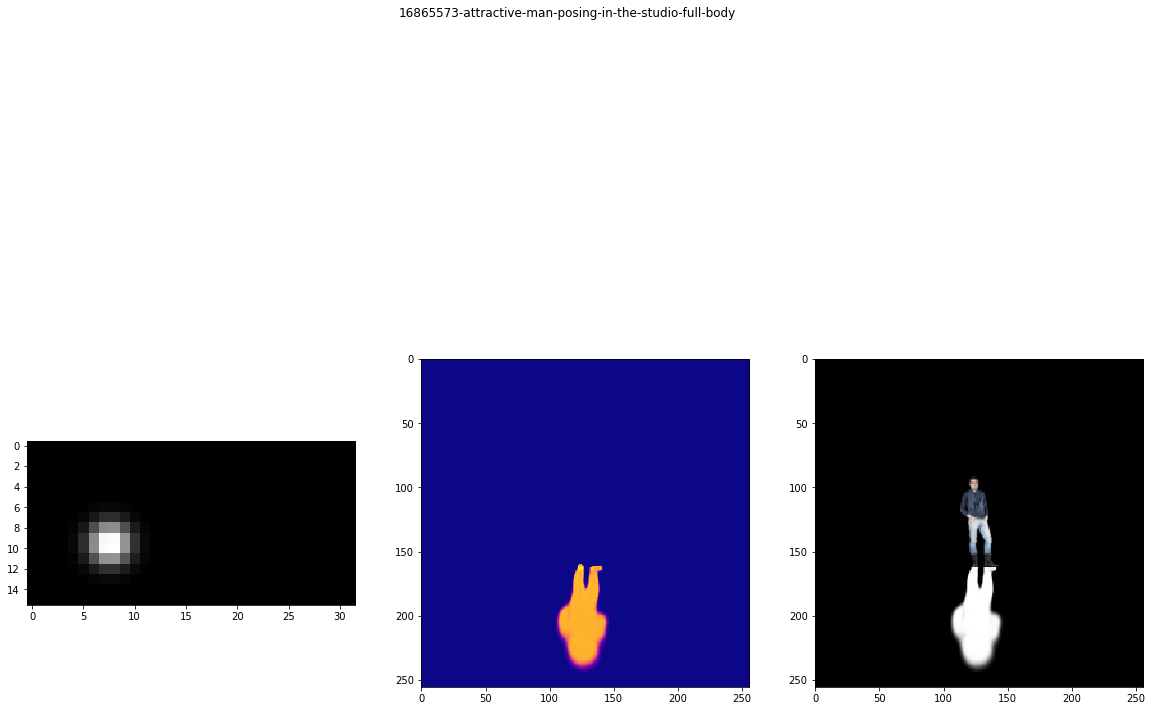

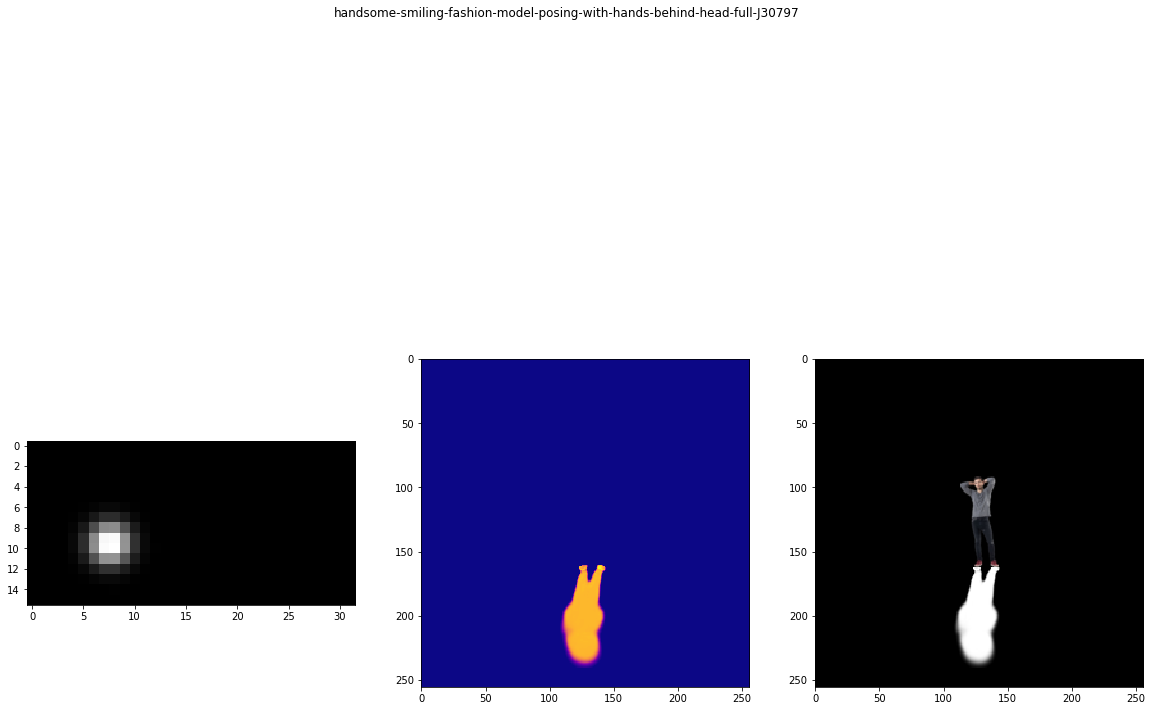

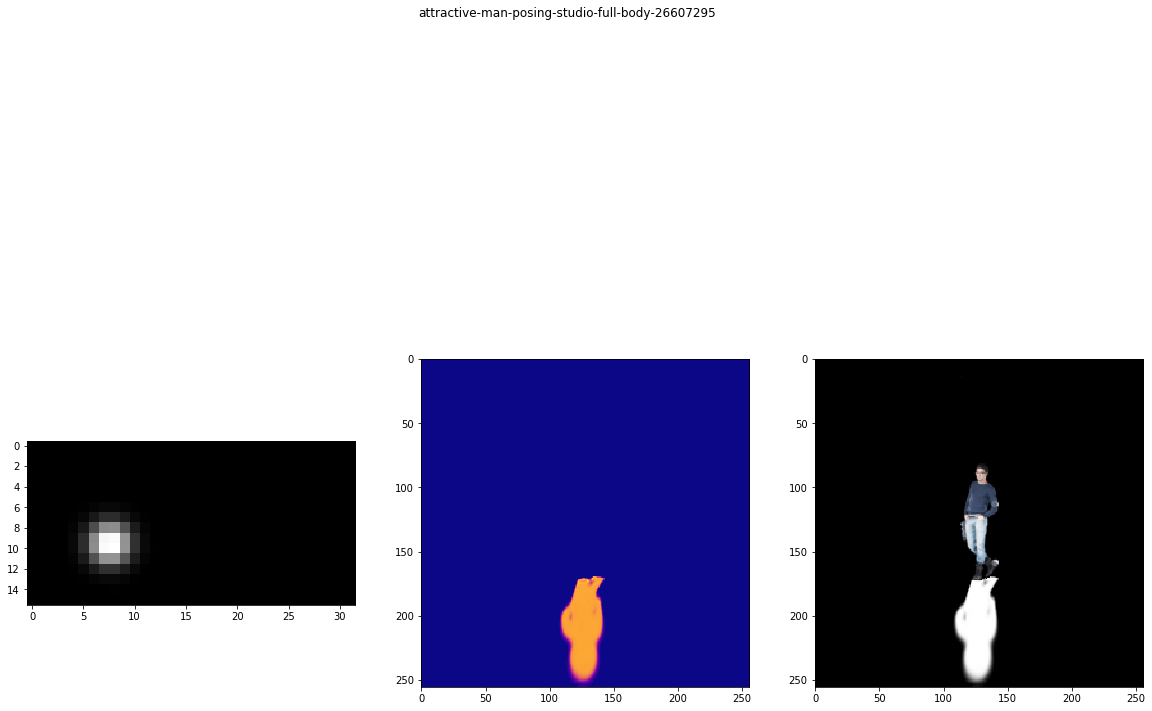

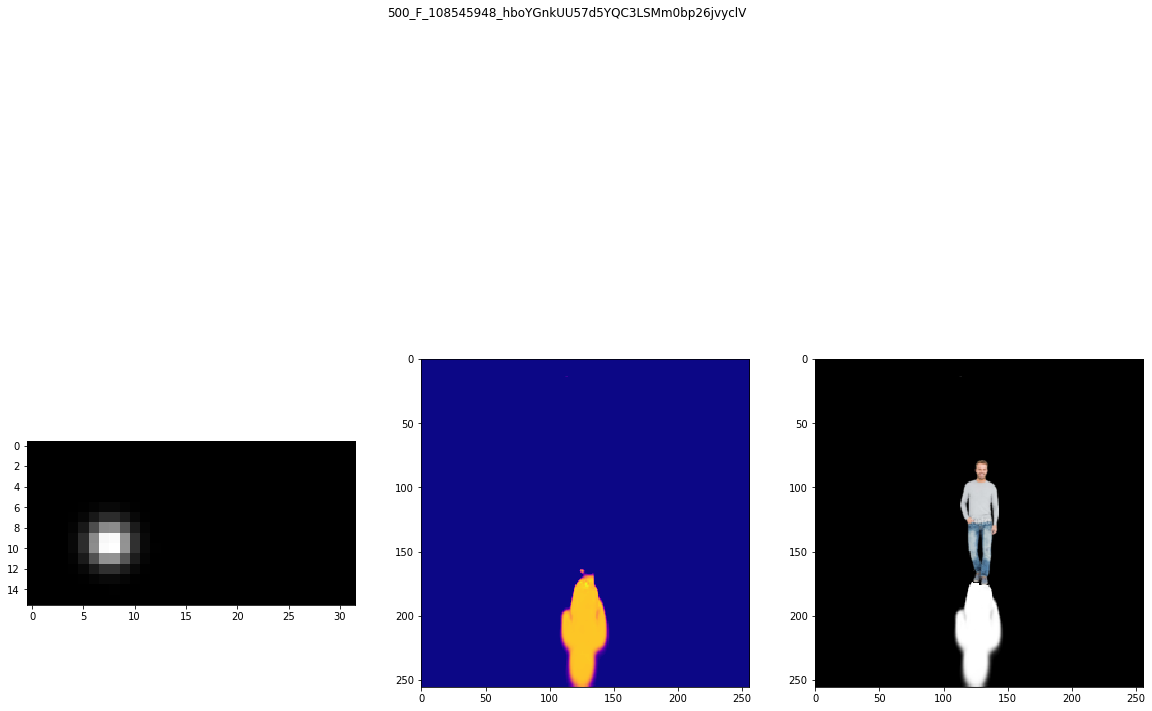

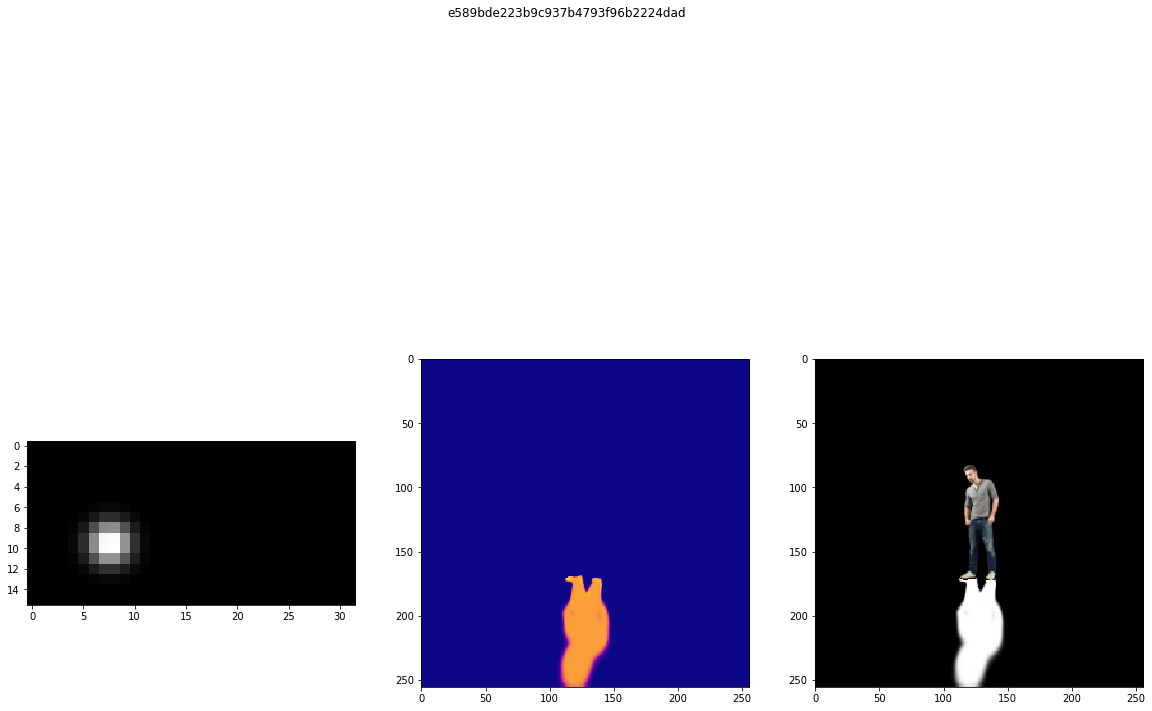

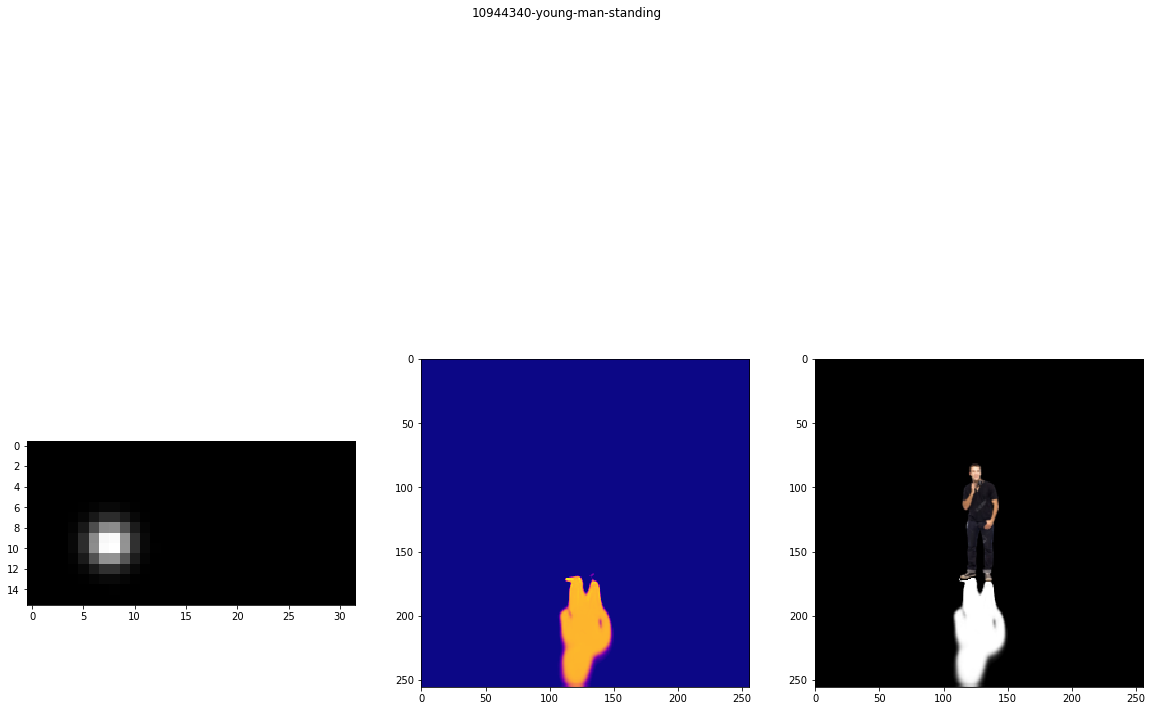

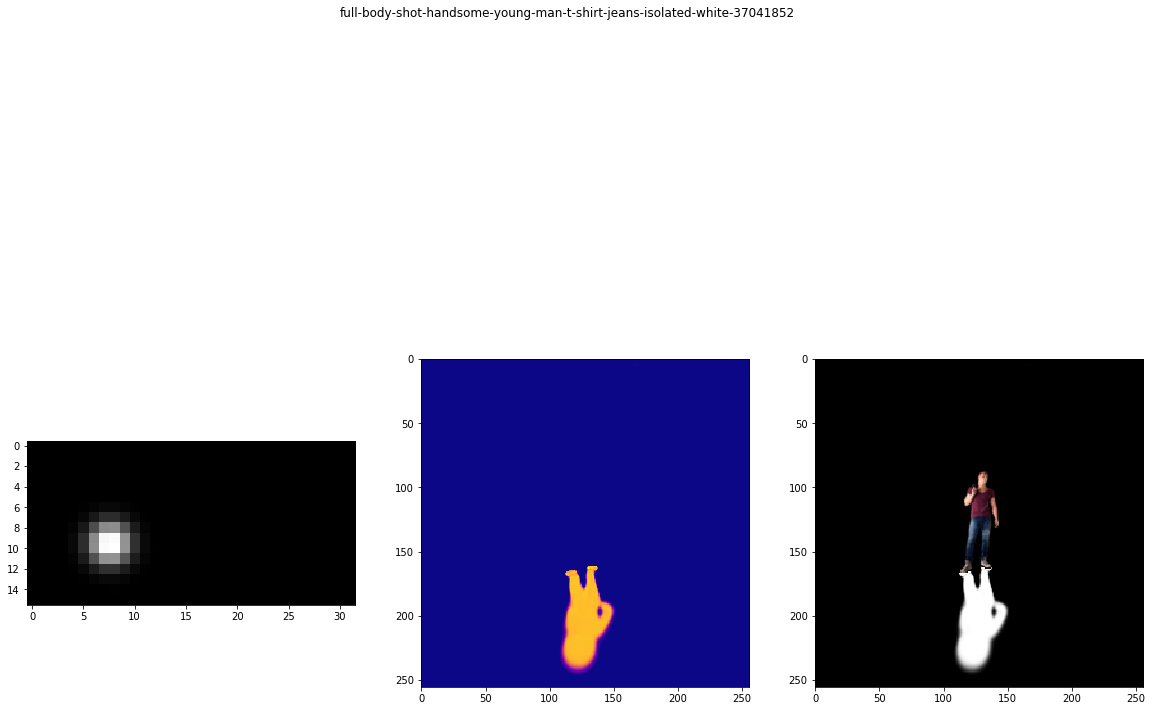

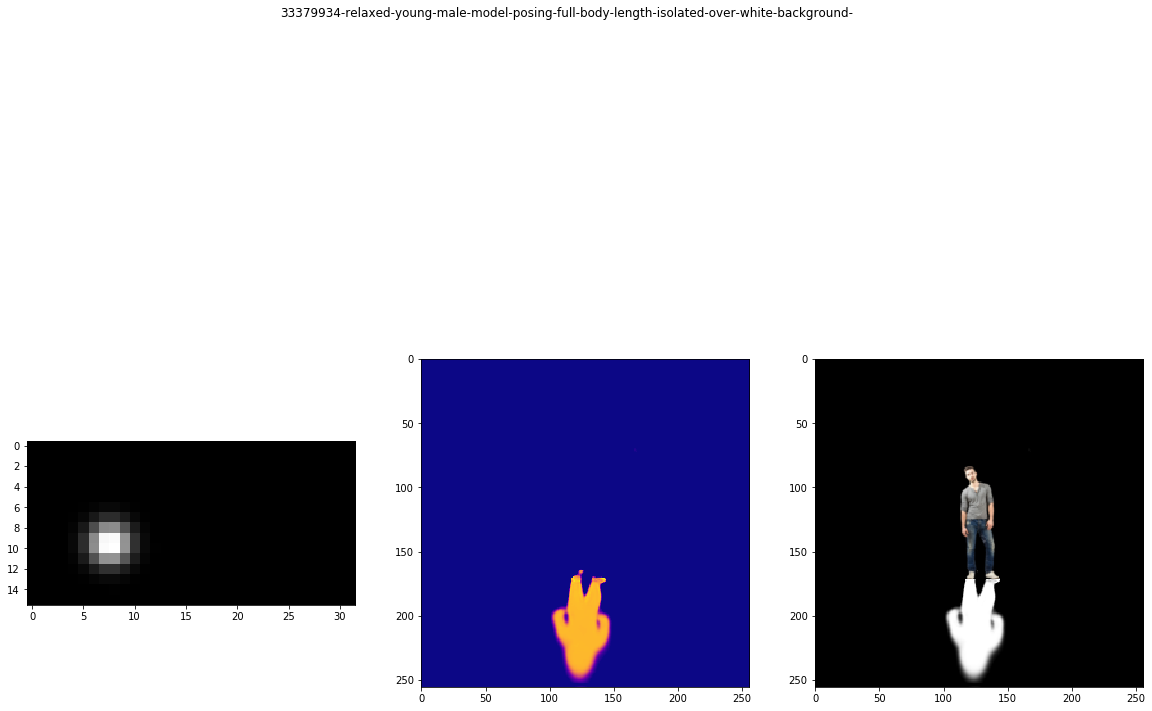

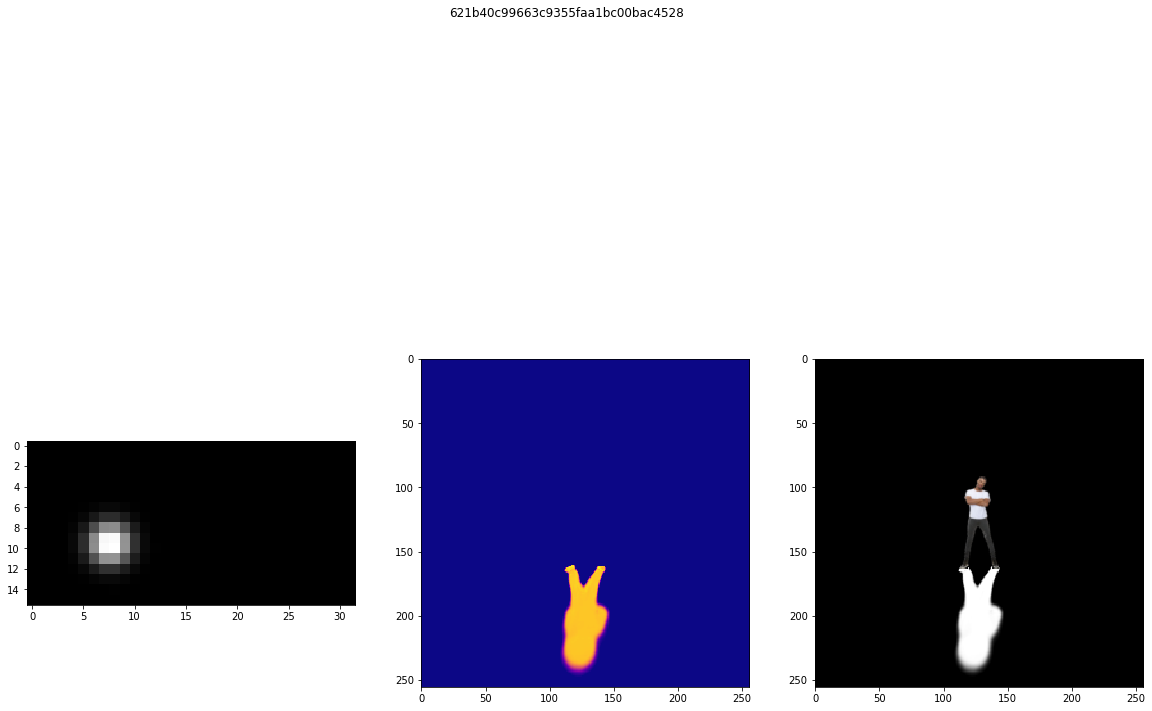

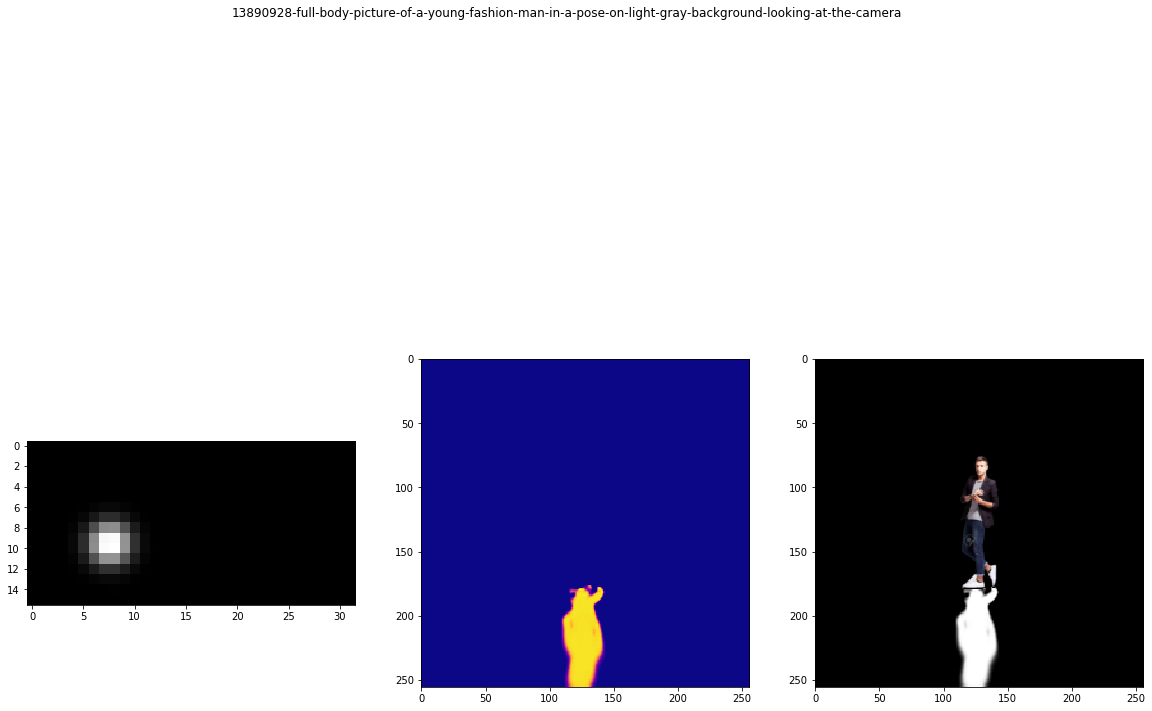

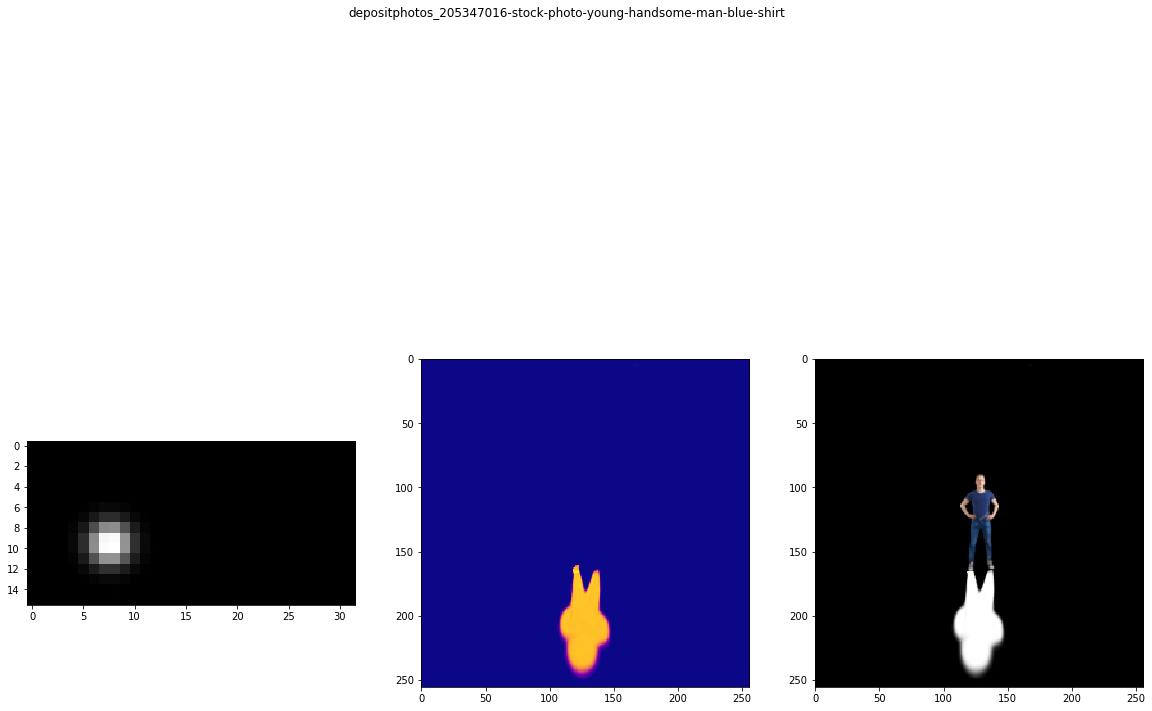

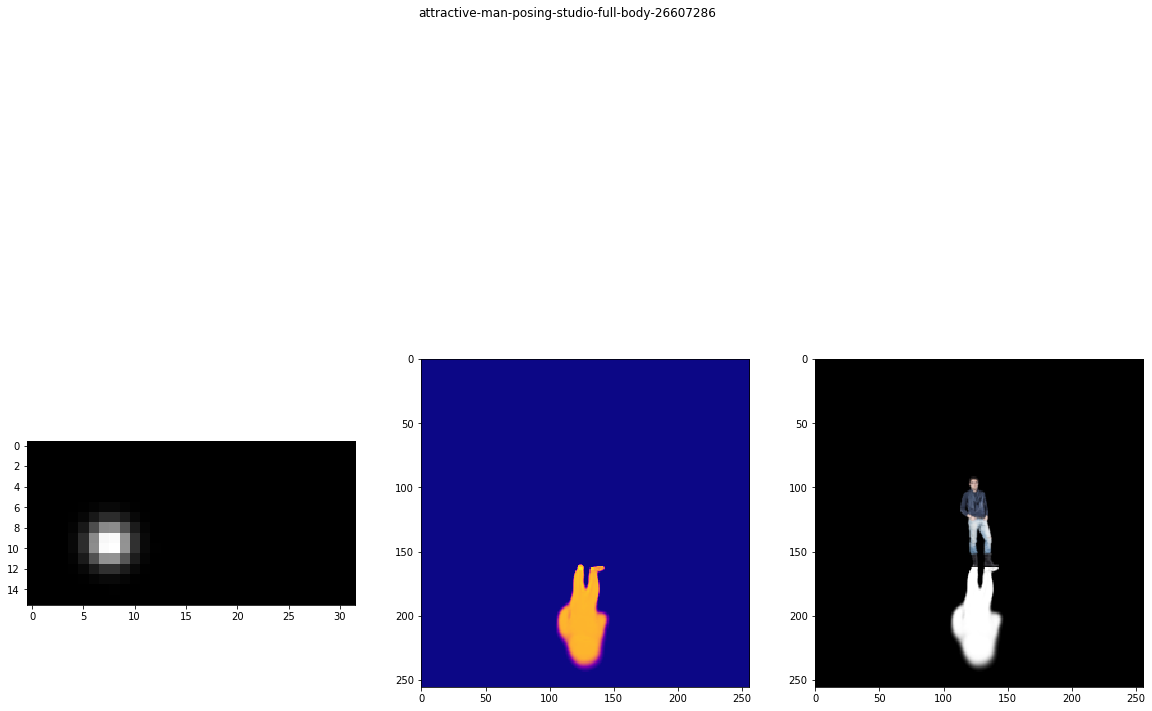

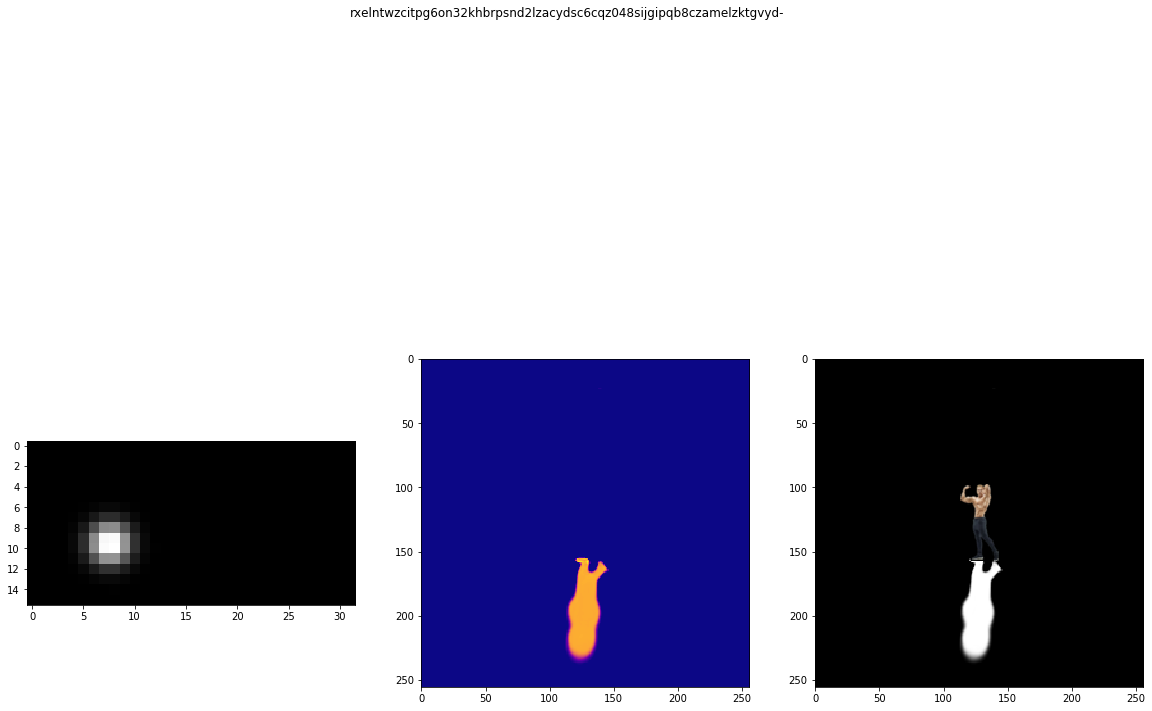

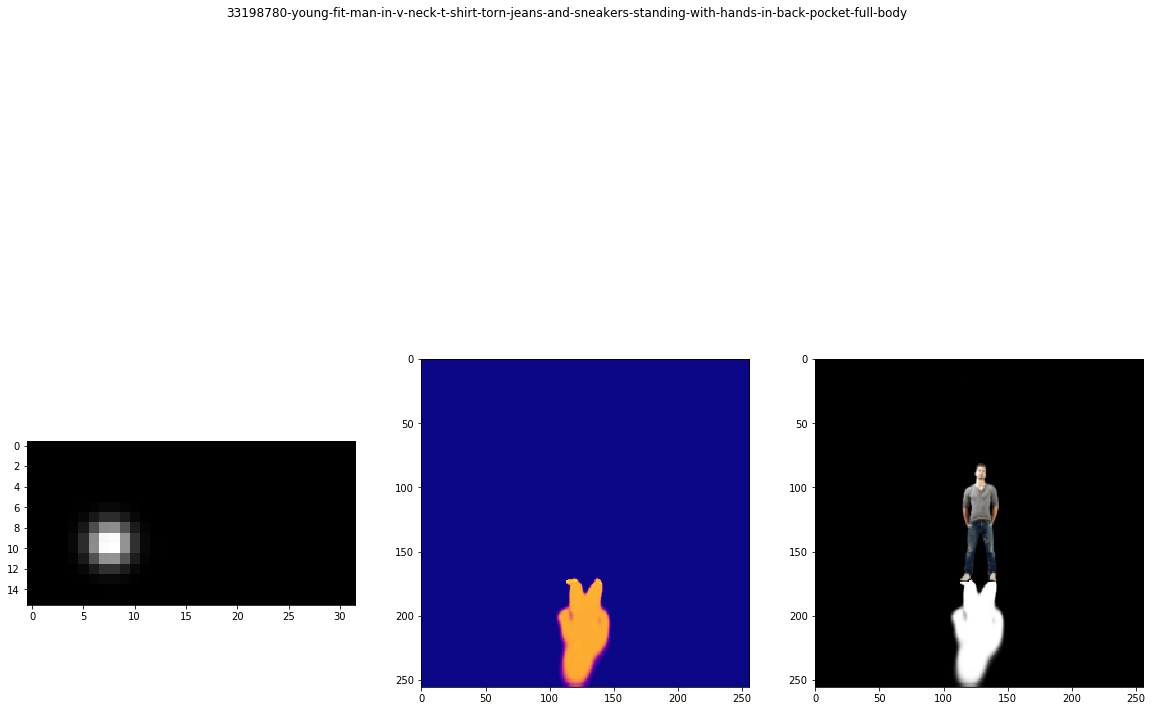

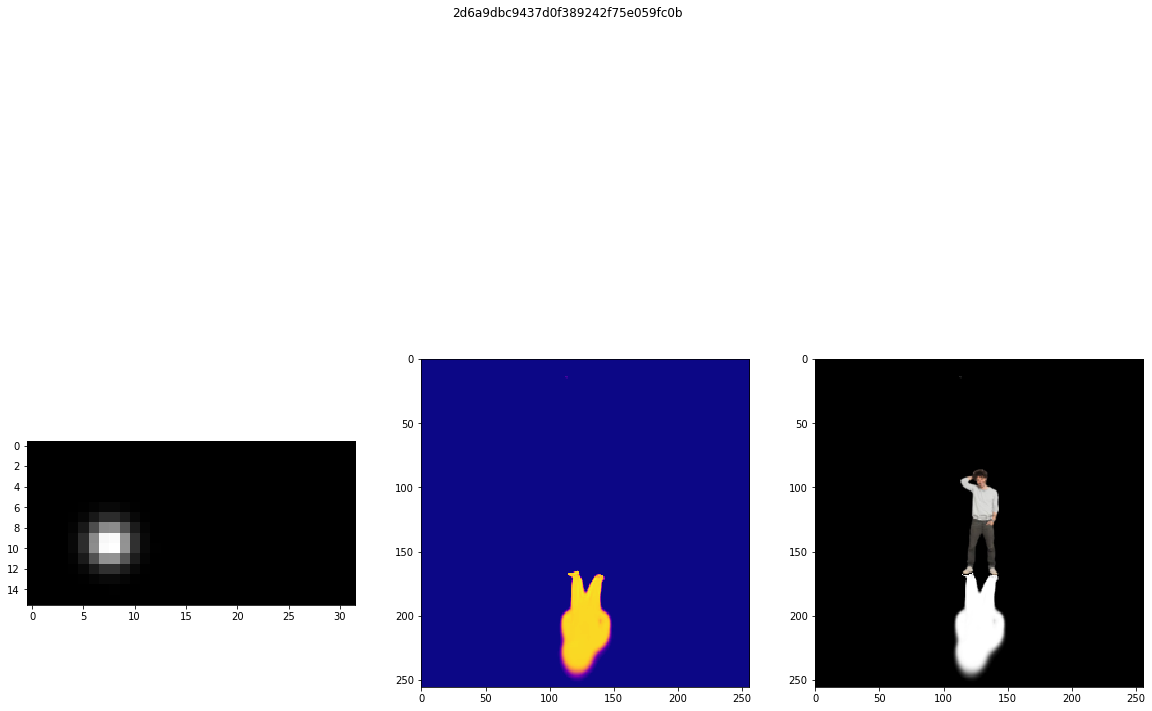

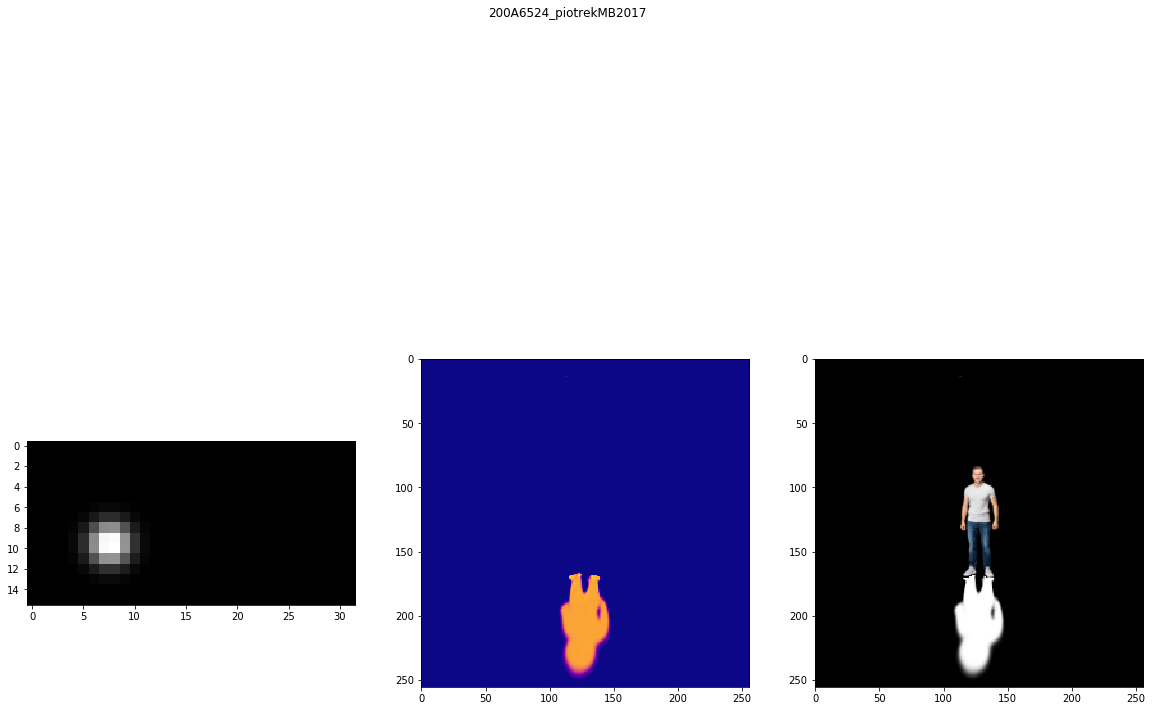

In [189]:
experiment_folder = os.path.join(experiment_path, 'real_human')
os.makedirs(experiment_folder, exist_ok=True)

from utils.utils_file import get_all_files
from PIL import Image, ImageDraw


real_human_img_path = get_all_files('real_human')
print('human imgs: {}'.format(len(real_human_img_path)))

testing_ibl = compute_ibl(512//4, 160).reshape((16,32,1))
for f in tqdm(real_human_img_path):
    cur_human_img = Image.open(os.path.join('real_human', f))
    cur_testing_img, cur_testing_mask = real_to_mask(np.array(cur_human_img))
    
    predicted_img = predict(cur_testing_mask, testing_ibl)
    title = '{}'.format(os.path.splitext(os.path.basename(f))[0])
    save_path = os.path.join(experiment_folder, title + '.pdf')
    plot_result(testing_ibl, predicted_img, cur_testing_img, title, save_path)

## Test on other objects

## Scale IBL